# Исследование объявлений о продаже квартир

В данном исследовании мы будем анализировать объявления о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Задача — установить параметры для определения рыночной цены квартиры и для дальнейшего построения автоматизированной системы для отслежки аномалий и мошенников.


1. [Обзор](#overview)
2. [Предобработка данных](#preprocessing)
3. [Изменение типа данных](#types)
    - [Оптимизация числовых данных](#int/float)
    - [Обработка обьектных типов](#object)
4. [Добавление дополнительных столбцов](#add.columns)
5. [Иследовательский анализ данных](#analysis)
    
    

In [1]:
!pip install geopy

from geopy.geocoders import Nominatim

import math
import pandas as pd
import datetime as dt

import warnings

import matplotlib.pyplot as plt

import seaborn as sns

sns.set()
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'


pd.set_option('display.float_format', '{:,.2f}'.format)

You should consider upgrading via the '/Users/mitya/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


## 1. Обзор<a id="overview"></a>

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
df.head()

total_images    last_price  total_area first_day_exposition  rooms  \
0            20 13,000,000.00      108.00  2019-03-07T00:00:00      3   
1             7  3,350,000.00       40.40  2018-12-04T00:00:00      1   
2            10  5,196,000.00       56.00  2015-08-20T00:00:00      2   
3             0 64,900,000.00      159.00  2015-07-24T00:00:00      3   
4             2 10,000,000.00      100.00  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70         16.00        51.00      8          NaN  ...   
1             nan         11.00        18.60      1          NaN  ...   
2             nan          5.00        34.30      4          NaN  ...   
3             nan         14.00          nan      9          NaN  ...   
4            3.03         14.00        32.00     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0         25.00      nan  Санкт-Петербург         18,863.00   
1         11.00     2.00   посёлок Шушары         12,817.00   
2          8.30     0.00  Санкт-Петербург         21,741.00   
3           nan     0.00  Санкт-Петербург         28,098.00   
4         41.00      nan  Санкт-Петербург         31,856.00   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0           16,028.00              1.00         482.00              2.00   
1           18,603.00              0.00            nan              0.00   
2           13,933.00              1.00          90.00              2.00   
3            6,800.00              2.00          84.00              3.00   
4            8,098.00              2.00         112.00              1.00   

   ponds_nearest  days_exposition  
0         755.00              nan  
1            nan            81.00  
2         574.00           558.00  
3         234.00           424.00  
4          48.00           121.00  

[5 rows x 22 columns]

In [4]:
df.describe().T

count         mean           std       min  \
total_images        23,699.00         9.86          5.68      0.00   
last_price          23,699.00 6,541,548.77 10,887,013.27 12,190.00   
total_area          23,699.00        60.35         35.65     12.00   
rooms               23,699.00         2.07          1.08      0.00   
ceiling_height      14,504.00         2.77          1.26      1.00   
floors_total        23,613.00        10.67          6.60      1.00   
living_area         21,796.00        34.46         22.03      2.00   
floor               23,699.00         5.89          4.89      1.00   
kitchen_area        21,421.00        10.57          5.91      1.30   
balcony             12,180.00         1.15          1.07      0.00   
airports_nearest    18,157.00    28,793.67     12,630.88      0.00   
cityCenters_nearest 18,180.00    14,191.28      8,608.39    181.00   
parks_around3000    18,181.00         0.61          0.80      0.00   
parks_nearest        8,079.00       490.80        342.32      1.00   
ponds_around3000    18,181.00         0.77          0.94      0.00   
ponds_nearest        9,110.00       517.98        277.72     13.00   
days_exposition     20,518.00       180.89        219.73      1.00   

                             25%          50%          75%            max  
total_images                6.00         9.00        14.00          50.00  
last_price          3,400,000.00 4,650,000.00 6,800,000.00 763,000,000.00  
total_area                 40.00        52.00        69.90         900.00  
rooms                       1.00         2.00         3.00          19.00  
ceiling_height              2.52         2.65         2.80         100.00  
floors_total                5.00         9.00        16.00          60.00  
living_area                18.60        30.00        42.30         409.70  
floor                       2.00         4.00         8.00          33.00  
kitchen_area                7.00         9.10        12.00         112.00  
balcony                     0.00         1.00         2.00           5.00  
airports_nearest       18,585.00    26,726.00    37,273.00      84,869.00  
cityCenters_nearest     9,238.00    13,098.50    16,293.00      65,968.00  
parks_around3000            0.00         0.00         1.00           3.00  
parks_nearest             288.00       455.00       612.00       3,190.00  
ponds_around3000            0.00         1.00         1.00           3.00  
ponds_nearest             294.00       502.00       729.00       1,344.00  
days_exposition            45.00        95.00       232.00       1,580.00

In [5]:
df.tail()

total_images    last_price  total_area first_day_exposition  rooms  \
23694             9  9,700,000.00      133.81  2017-03-21T00:00:00      3   
23695            14  3,100,000.00       59.00  2018-01-15T00:00:00      3   
23696            18  2,500,000.00       56.70  2018-02-11T00:00:00      2   
23697            13 11,475,000.00       76.75  2017-03-28T00:00:00      2   
23698             4  1,350,000.00       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
23694            3.70          5.00        73.30      3          NaN  ...   
23695             nan          5.00        38.00      4          NaN  ...   
23696             nan          3.00        29.70      1          NaN  ...   
23697            3.00         17.00          nan     12          NaN  ...   
23698            2.50          5.00        12.30      1          NaN  ...   

       kitchen_area  balcony        locality_name  airports_nearest  \
23694         13.83      nan      Санкт-Петербург         24,665.00   
23695          8.50      nan                Тосно               nan   
23696           nan      nan     село Рождествено               nan   
23697         23.30     2.00      Санкт-Петербург         39,140.00   
23698          9.00      nan  поселок Новый Учхоз               nan   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
23694            4,232.00              1.00         796.00              3.00   
23695                 nan               nan            nan               nan   
23696                 nan               nan            nan               nan   
23697           10,364.00              2.00         173.00              3.00   
23698                 nan               nan            nan               nan   

       ponds_nearest  days_exposition  
23694         381.00              nan  
23695            nan            45.00  
23696            nan              nan  
23697         196.00           602.00  
23698            nan              nan  

[5 rows x 22 columns]

In [6]:
df.sample()

total_images   last_price  total_area first_day_exposition  rooms  \
7602             4 4,108,100.00       76.65  2016-07-04T00:00:00      1   

      ceiling_height  floors_total  living_area  floor is_apartment  ...  \
7602             nan         16.00        45.00      7        False  ...   

      kitchen_area  balcony  locality_name  airports_nearest  \
7602          9.25     0.00     Всеволожск               nan   

     cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
7602                 nan               nan            nan               nan   

      ponds_nearest  days_exposition  
7602            nan            14.00  

[1 rows x 22 columns]

## 2. Предобработка данных <a id="preprocessing"></a>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В данных много пропущенных значений, напишем функцию для анализа все пропусков

In [8]:
def na_describe(df):
    na_df = pd.concat([df.isna().sum(), df.isna().sum()/len(df)*100], axis=1)
    na_df.columns = ["count", "% missing"]
    na_df = na_df[na_df["count"] > 0]
    na_df = na_df.sort_values(by="% missing", ascending=False)
    return na_df

In [9]:
display(na_describe(df))

count  % missing
is_apartment         20924      88.29
parks_nearest        15620      65.91
ponds_nearest        14589      61.56
balcony              11519      48.61
ceiling_height        9195      38.80
airports_nearest      5542      23.38
cityCenters_nearest   5519      23.29
parks_around3000      5518      23.28
ponds_around3000      5518      23.28
days_exposition       3181      13.42
kitchen_area          2278       9.61
living_area           1903       8.03
floors_total            86       0.36
locality_name           49       0.21

В столбце 'ceiling_height' почти 40% пропущенных данных. Возможно у владельцев не было информации о высоте потолков и поэтому она отсутствует. Посмотрим на данные которые у нас есть в этом столбце

In [10]:
df.ceiling_height.describe()

count   14,504.00
mean         2.77
std          1.26
min          1.00
25%          2.52
50%          2.65
75%          2.80
max        100.00
Name: ceiling_height, dtype: float64

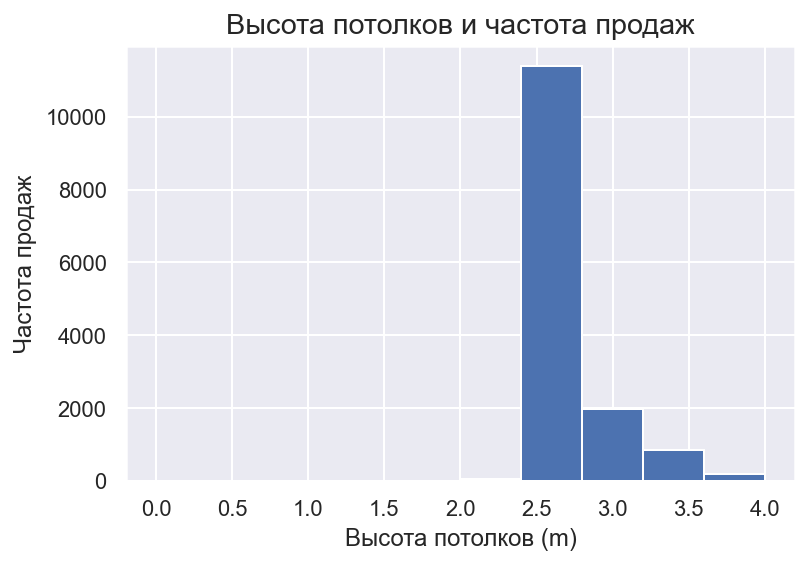

In [11]:
df.ceiling_height.hist(bins=10, range=(0,4));
plt.title('Высота потолков и частота продаж', size='large');
plt.xlabel('Высота потолков (m)');
plt.ylabel('Частота продаж');

<div class="alert alert-block alert-warning">
<b>Remarks:</b> 
    
Дальше будут проекты, где тебе придется строить очень много графиков, поэтому лучше сразу их правильно строить. На данном графике у тебя должны быть подписаны оси, ось Y должна содержать еще размерность данных (шт., млн. и т.д.). Оси и заголовок должны быть на одном языке. В заголовке еще можно написать за какой период у нас данные. Поправь и другие графики в проекте.

Правильное оформление графиков сильно повышает вероятность сдачи проекта с первого раза ;)
    
Также скину тебе сайт с подборкой крутых примеров на разных библиотеках:
    
https://python-graph-gallery.com/ ✔

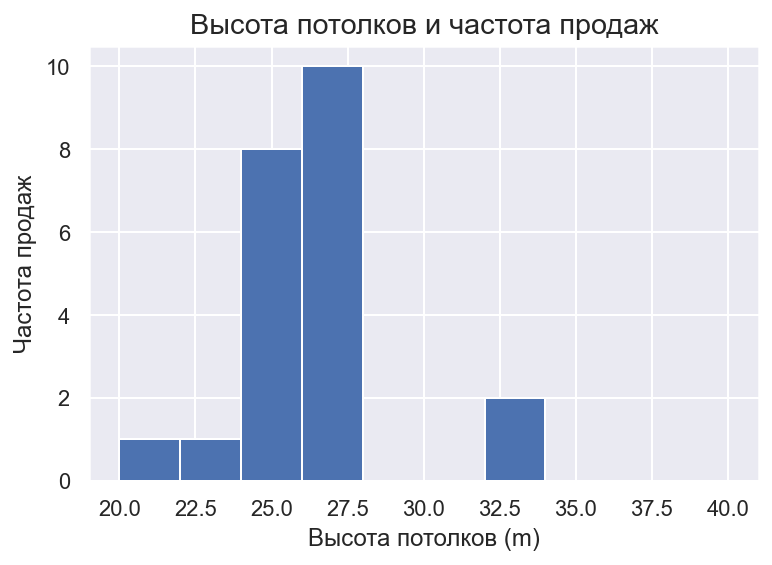

In [12]:
df.ceiling_height.hist(bins=10, range=(20,40));
plt.title('Высота потолков и частота продаж', size='large');
plt.xlabel('Высота потолков (m)');
plt.ylabel('Частота продаж');


Высота потолков в 25 метров кажется ошибочной, скорее всего забыли написать запятую

In [13]:
df[df['ceiling_height']>5].head(10)

total_images     last_price  total_area first_day_exposition  rooms  \
355             17   3,600,000.00       55.20  2018-07-12T00:00:00      2   
464             15  66,571,000.00      280.30  2015-06-11T00:00:00      6   
1026            20 155,000,000.00      310.00  2018-10-12T00:00:00      5   
1388            20  59,800,000.00      399.00  2015-01-21T00:00:00      5   
3148            14   2,900,000.00       75.00  2018-11-12T00:00:00      3   
3474             3   1,400,000.00       30.00  2018-03-16T00:00:00      1   
4643             0   4,300,000.00       45.00  2018-02-01T00:00:00      2   
4876             7   3,000,000.00       25.00  2017-09-27T00:00:00      0   
5076             0   3,850,000.00       30.50  2018-10-03T00:00:00      1   
5246             0   2,500,000.00       54.00  2017-10-13T00:00:00      2   

      ceiling_height  floors_total  living_area  floor is_apartment  ...  \
355            25.00          5.00        32.00      2        False  ...   
464             5.20          8.00       159.50      7          NaN  ...   
1026            5.30          3.00       190.00      3          NaN  ...   
1388            5.60          6.00          nan      6          NaN  ...   
3148           32.00          3.00        53.00      2          NaN  ...   
3474            8.00          5.00        15.30      2        False  ...   
4643           25.00          9.00        30.00      2          NaN  ...   
4876           27.00         25.00        17.00     17          NaN  ...   
5076           24.00          5.00        19.50      1         True  ...   
5246           27.00          5.00        30.00      3          NaN  ...   

      kitchen_area  balcony    locality_name  airports_nearest  \
355            nan     2.00          Гатчина               nan   
464          21.10     0.00  Санкт-Петербург         26,316.00   
1026         63.00     2.00  Санкт-Петербург         24,899.00   
1388           nan     0.00  Санкт-Петербург         26,204.00   
3148          8.00      nan           Волхов               nan   
3474          7.30      nan    деревня Нурма               nan   
4643          7.00     1.00  Санкт-Петербург         12,016.00   
4876           nan     2.00   посёлок Мурино               nan   
5076          5.50      nan  Санкт-Петербург         29,686.00   
5246          9.00     2.00     деревня Мины               nan   

     cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
355                  nan               nan            nan               nan   
464             6,655.00              3.00         187.00              1.00   
1026            4,785.00              0.00            nan              1.00   
1388            6,934.00              2.00         149.00              2.00   
3148                 nan               nan            nan               nan   
3474                 nan               nan            nan               nan   
4643           13,256.00              1.00         658.00              1.00   
4876                 nan               nan            nan               nan   
5076            8,389.00              3.00         397.00              1.00   
5246                 nan               nan            nan               nan   

      ponds_nearest  days_exposition  
355             nan           259.00  
464          616.00           578.00  
1026         603.00              nan  
1388         577.00           719.00  
3148            nan              nan  
3474            nan           125.00  
4643         331.00           181.00  
4876            nan            28.00  
5076         578.00             7.00  
5246            nan           540.00  

[10 rows x 22 columns]

Высота потолков может быть больше 5-ти метров. Но даже для элитных домов это очень редко встречается.

In [14]:
df[df['last_price']> 150000000].sort_values('ceiling_height', ascending=False).head(5)

total_images     last_price  total_area first_day_exposition  rooms  \
1026             20 155,000,000.00      310.00  2018-10-12T00:00:00      5   
19865            20 180,000,000.00      347.00  2015-01-21T00:00:00      8   
2536             16 159,984,000.00      242.40  2015-08-27T00:00:00      4   
1436             19 330,000,000.00      190.00  2018-04-04T00:00:00      3   
13749             7 240,000,000.00      410.00  2017-04-01T00:00:00      6   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
1026             5.30          3.00       190.00      3          NaN  ...   
19865            3.90          6.00       260.00      3          NaN  ...   
2536             3.85          9.00       131.00      7          NaN  ...   
1436             3.50          7.00        95.00      5          NaN  ...   
13749            3.40          7.00       218.00      7          NaN  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
1026          63.00     2.00  Санкт-Петербург         24,899.00   
19865         45.00     0.00  Санкт-Петербург         23,962.00   
2536          20.00     0.00  Санкт-Петербург         21,946.00   
1436          40.00      nan  Санкт-Петербург         23,011.00   
13749         40.00     0.00  Санкт-Петербург         32,440.00   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
1026             4,785.00              0.00            nan              1.00   
19865            3,794.00              2.00         537.00              3.00   
2536             2,242.00              1.00         679.00              1.00   
1436             1,197.00              3.00         519.00              3.00   
13749            5,297.00              0.00            nan              2.00   

       ponds_nearest  days_exposition  
1026          603.00              nan  
19865         501.00           834.00  
2536          227.00           501.00  
1436          285.00           233.00  
13749         198.00           199.00  

[5 rows x 22 columns]

Разумно полагать что выше потолков не бывает и что все наши данные где высота потолка больше 5.5 метров - просто ошибки. Может даже просто опечатки. Разделим цены на несколько категорий и в соответствии с ними заполним данные о высоте потолков.

In [15]:
df.last_price.describe()

count        23,699.00
mean      6,541,548.77
std      10,887,013.27
min          12,190.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,800,000.00
max     763,000,000.00
Name: last_price, dtype: float64

In [16]:
def price_cat(row):
    if row < 4650000:
        return 'low'
    elif 4650000 <= row < 6800000:
        return 'medium'
    return 'high'
    
df['price_cat'] = df.last_price.apply(price_cat)
df.groupby('price_cat')['ceiling_height'].agg(['count', 'mean', 'median']).sort_values('mean')

count  mean  median
price_cat                     
low         6716  2.67    2.55
medium      3845  2.72    2.65
high        3943  3.00    2.90

Во первых мы видим что у высоты потолков и цены квартир линейная связь. У квартир ценой 465 тысяч и больше потолки выше чем у квартир ценой до 465 и 680 тысяч. А у самых дорогих - самые высокие потолки.

In [17]:
ceiling_median = df.groupby('price_cat').agg({'ceiling_height': 'median'}).sort_values('ceiling_height').reset_index()
ceiling_median

price_cat  ceiling_height
0       low            2.55
1    medium            2.65
2      high            2.90

Избавимся от выбросов и заполним пустые значения медианой высоты потолков той же категории цены.

In [18]:
ceiling_map_dict = {row['price_cat']: row['ceiling_height'] for index, row in ceiling_median.iterrows()}
df['ceiling_height'] = df['ceiling_height'].fillna(df['price_cat'].map(ceiling_map_dict))


In [19]:
df.ceiling_height.describe()

count   23,699.00
mean         2.72
std          0.99
min          1.00
25%          2.55
50%          2.60
75%          2.80
max        100.00
Name: ceiling_height, dtype: float64

In [20]:
df.ceiling_height.sort_values(ascending=False).head()

22869   100.00
22336    32.00
3148     32.00
21377    27.50
4876     27.00
Name: ceiling_height, dtype: float64

Избавимся от выбросов заполнив их средним значением

In [21]:
df.loc[df['ceiling_height'] > 5.5, 'ceiling_height'] = df['ceiling_height'].mean()

In [22]:
df.ceiling_height.describe()

count   23,699.00
mean         2.70
std          0.24
min          1.00
25%          2.55
50%          2.60
75%          2.80
max          5.50
Name: ceiling_height, dtype: float64

In [23]:
df.ceiling_height.isna().sum()

0

In [24]:
df.living_area.describe()

count   21,796.00
mean        34.46
std         22.03
min          2.00
25%         18.60
50%         30.00
75%         42.30
max        409.70
Name: living_area, dtype: float64

In [25]:
df.living_area.isna().mean()

0.08029874678256467

У нас 8 процентов отсутсвующих данных. Приглядимся к ним по ближе

In [26]:
df[df['living_area'].isna()].head(10)

total_images    last_price  total_area first_day_exposition  rooms  \
3               0 64,900,000.00      159.00  2015-07-24T00:00:00      3   
7               5  7,915,000.00       71.60  2019-04-18T00:00:00      2   
30             12  2,200,000.00       32.80  2018-02-19T00:00:00      1   
37             10  1,990,000.00       45.80  2017-10-28T00:00:00      2   
44             13  5,350,000.00       40.00  2018-11-18T00:00:00      1   
59             15  6,300,000.00       46.50  2017-03-06T00:00:00      1   
60              3  2,740,000.00       35.00  2018-01-01T00:00:00      1   
81              9 10,949,000.00       68.00  2018-12-27T00:00:00      1   
82              3  4,500,000.00       80.50  2018-01-15T00:00:00      3   
116            18 10,999,000.00       97.20  2017-11-13T00:00:00      3   

     ceiling_height  floors_total  living_area  floor is_apartment  ...  \
3              2.90         14.00          nan      9          NaN  ...   
7              2.90         24.00          nan     22          NaN  ...   
30             2.55          9.00          nan      2          NaN  ...   
37             2.50          5.00          nan      1          NaN  ...   
44             2.65         22.00          nan      3          NaN  ...   
59             2.65         13.00          nan     13          NaN  ...   
60             2.55         12.00          nan      8          NaN  ...   
81             2.90         10.00          nan      6          NaN  ...   
82             2.55         25.00          nan     16          NaN  ...   
116            2.50         16.00          nan     16          NaN  ...   

     balcony                        locality_name  airports_nearest  \
3       0.00                      Санкт-Петербург         28,098.00   
7       2.00                      Санкт-Петербург         23,982.00   
30       nan                             Коммунар               nan   
37       nan  поселок городского типа Красный Бор               nan   
44      1.00                      Санкт-Петербург         30,471.00   
59       nan                      Санкт-Петербург         11,125.00   
60       nan                       посёлок Мурино               nan   
81       nan                      Санкт-Петербург               nan   
82       nan                       посёлок Шушары         12,430.00   
116     5.00                      Санкт-Петербург         19,426.00   

     cityCenters_nearest parks_around3000  parks_nearest  ponds_around3000  \
3               6,800.00             2.00          84.00              3.00   
7              11,634.00             0.00            nan              0.00   
30                   nan              nan            nan               nan   
37                   nan              nan            nan               nan   
44             11,603.00             1.00         620.00              1.00   
59             14,501.00             0.00            nan              0.00   
60                   nan              nan            nan               nan   
81                   nan              nan            nan               nan   
82             18,217.00             0.00            nan              0.00   
116            21,138.00             0.00            nan              2.00   

     ponds_nearest  days_exposition  price_cat  
3           234.00           424.00       high  
7              nan              nan       high  
30             nan            63.00        low  
37             nan           196.00        low  
44        1,152.00              nan     medium  
59             nan           336.00     medium  
60             nan            11.00        low  
81             nan              nan       high  
82             nan            60.00        low  
116         390.00           394.00       high  

[10 rows x 23 columns]

In [27]:
df.groupby('total_area')['living_area'].agg(['count', 'mean', 'median'])

count   mean  median
total_area                      
12.00           1  10.00   10.00
13.00           1  10.00   10.00
13.20           0    nan     nan
14.00           1  11.00   11.00
15.00           0    nan     nan
...           ...    ...     ...
590.00          1 409.00  409.00
618.00          1 258.00  258.00
631.00          0    nan     nan
631.20          1 322.30  322.30
900.00          1 409.70  409.70

[2182 rows x 3 columns]

In [28]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_cat'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [30]:
df['total_living_coeff'] = df.living_area / df.total_area

In [31]:
df['total_living_coeff'].describe()

count   21,796.00
mean         0.56
std          0.11
min          0.02
25%          0.50
50%          0.57
75%          0.64
max          1.00
Name: total_living_coeff, dtype: float64

In [32]:
price_living_coeff = df.groupby('price_cat').agg({'total_living_coeff': 'mean'}).reset_index()
price_living_coeff 

price_cat  total_living_coeff
0      high                0.57
1       low                0.56
2    medium                0.57

Видно что соотношение жилая_площадь / общая_площадь квартир очень мало отличаются в зависимости от цены. Всего на один процент от категории к категории. Можно заполнить недостающие данные жилой площали просто умножив общую площадь на найденный нами коеффицент.

In [33]:
map_dict = {row['price_cat']: row['total_living_coeff'] for index, row in price_living_coeff.iterrows()}
df['living_area'] = df.living_area.fillna(df['price_cat'].map(map_dict))
df.living_area.isna().mean()

0.0

In [34]:
df.living_area.describe()

count   23,699.00
mean        31.74
std         23.05
min          0.56
25%         17.80
50%         29.00
75%         41.10
max        409.70
Name: living_area, dtype: float64

Данные о жилой площади мы заполнили теперь рассмотрим столбец 'is_apartment'

In [35]:
df.is_apartment.unique()

array([nan, False, True], dtype=object)

In [36]:
df.groupby('is_apartment')['total_area'].agg(['count', 'mean', 'median'])

count  mean  median
is_apartment                     
False          2725 61.12   54.00
True             50 83.33   64.00

По этому параметру очень сложно сделать какие-либо выводы. У нас слишком мало значений - только 50 квартир типа "апатраменты" и данные не репрезентативны.
Удалим этот столбец чтобы он нам не мешал в дальнейшем анализе

In [37]:
df.drop('is_apartment', inplace=True, axis=1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   studio                23699 non-null  bool   
 10  open_plan             23699 non-null  bool   
 11  kitchen_area          21421 non-null  float64
 12  balcony               12180 non-null  float64
 13  locality_name         23650 non-null  object 
 14  airports_nearest      18157 non-null  float64
 15  cityCenters_nearest

Дополним теперь наш новый столбец 'total_living_coeff'

In [39]:
df['total_living_coeff'] = df['living_area'] / df['total_area']

In [40]:
df.floors_total.isna().mean()

0.0036288450989493226

In [41]:
df.floors_total.describe()

count   23,613.00
mean        10.67
std          6.60
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

In [42]:
df.floors_total.sort_values(ascending=False).head(10)

2253    60.00
16731   52.00
16934   37.00
397     36.00
5807    36.00
11079   36.00
5749    35.00
20938   35.00
871     35.00
13975   35.00
Name: floors_total, dtype: float64

60 этажей выглядит как выброс. Скорее всего это просто ошибка. Может вместо 6 написали 60. Проверим остальные данные этих обьявлений

In [43]:
df[df['floors_total'] > 35].sort_values(by='floors_total', ascending=False)

total_images   last_price  total_area first_day_exposition  rooms  \
2253             12 3,800,000.00       45.50  2018-06-28T00:00:00      2   
16731             9 3,978,000.00       40.00  2018-09-24T00:00:00      1   
16934             5 4,100,000.00       40.00  2017-10-17T00:00:00      1   
397              15 5,990,000.00       54.00  2018-03-22T00:00:00      2   
5807             17 8,150,000.00       80.00  2019-01-09T00:00:00      2   
11079            16 9,200,000.00       75.00  2019-02-22T00:00:00      2   

       ceiling_height  floors_total  living_area  floor  studio  ...  \
2253             2.88         60.00        27.40      4   False  ...   
16731            2.65         52.00        10.50     18   False  ...   
16934            1.75         37.00        17.40      5   False  ...   
397              2.65         36.00        21.40     28   False  ...   
5807             2.72         36.00        41.00     13   False  ...   
11079            2.70         36.00        40.00     29   False  ...   

         locality_name  airports_nearest  cityCenters_nearest  \
2253         Кронштадт         67,763.00            49,488.00   
16731  Санкт-Петербург         20,728.00            12,978.00   
16934  Санкт-Петербург         18,732.00            20,444.00   
397    Санкт-Петербург         18,732.00            20,444.00   
5807   Санкт-Петербург         18,732.00            20,444.00   
11079  Санкт-Петербург         18,732.00            20,444.00   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
2253              2.00         342.00              3.00         614.00   
16731             1.00         793.00              0.00            nan   
16934             0.00            nan              3.00          80.00   
397               0.00            nan              3.00          80.00   
5807              0.00            nan              3.00          80.00   
11079             0.00            nan              3.00          80.00   

       days_exposition  price_cat  total_living_coeff  
2253            166.00        low                0.60  
16731            45.00        low                0.26  
16934            71.00        low                0.43  
397              11.00     medium                0.40  
5807             38.00       high                0.51  
11079              nan       high                0.53  

[6 rows x 23 columns]

В Кронштадте нет зданий в 60 этажей (загуглил) поэтому скорее всего это ошибка и этажей на самом деле 6. А что насчет значения 52 , 37 и 36?

52 этажных зданий в питере тоже нет а вот ЖК с 37 этажами есть. ЖК «Князь Александр Невский» был самм высоким зданием в Питере до 2013 года и в обьявлении явно квартиры из него. И по данным геолокации видно что квартиры в 37 этажном ЖК они в находятся в одном и том же здании. В данних указано 36 и 37 этажей и так как заполняли эти данные люди скорее всего они точно не знали сколько в здании этажей 36 или 37. Данная ошибка не повлияет на нашу выборку, но все же сменим 36 на 37(данные с гугла)

In [44]:
df.loc[df['floors_total'] == 36, 'floors_total'] = 37
df.loc[df['floors_total'] == 60, 'floors_total'] = 6

Посмотрим если ли обьявления с того же дома чило этажей которого 52

In [45]:
df[(df['airports_nearest'] == 20728.00) & (df['cityCenters_nearest'] == 12978.00)]

total_images   last_price  total_area first_day_exposition  rooms  \
16731             9 3,978,000.00       40.00  2018-09-24T00:00:00      1   

       ceiling_height  floors_total  living_area  floor  studio  ...  \
16731            2.65         52.00        10.50     18   False  ...   

         locality_name  airports_nearest  cityCenters_nearest  \
16731  Санкт-Петербург         20,728.00            12,978.00   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
16731             1.00         793.00              0.00            nan   

       days_exposition  price_cat  total_living_coeff  
16731            45.00        low                0.26  

[1 rows x 23 columns]

Довольно странно, из данного здания больше обьявлений нет, и сведений о здании в 52 этажа тоже нет. Удалим эту строку и продолжим анализ

In [46]:
df.drop(axis=0, index=16731, inplace=True)

In [47]:
locality_floors = df.groupby('locality_name').agg({'floors_total': 'mean', 'floor':'max'}).reset_index()
locality_floors.head()

locality_name  floors_total  floor
0  Бокситогорск          4.19      5
1      Волосово          4.56      5
2        Волхов          4.86      7
3    Всеволожск          8.39     20
4        Выборг          5.87     10

In [48]:
locality_floors["floors_total"] = locality_floors["floors_total"].astype('int')

floor_map = {row["locality_name"]: max(row["floors_total"], row["floor"]) for i, row in locality_floors.iterrows()}

df['floors_total'] = df['floors_total'].fillna(df["locality_name"].map(floor_map))


In [49]:
df.loc[df['floors_total'].isna(), 'floors_total'] = df[df['floors_total'].isna()]['floor']

Мы заменили пустые значения в колонке 'floors_total' в соответствии со средним значением 'floors_total' и самым высоким значением 'floors' в том районе где появилось наше обьявление. В рядах где небыло указанно 'locality_name' мы заполнили количество этажей на значение указанное в столбце 'floor'

In [50]:
df.kitchen_area.describe()

count   21,420.00
mean        10.57
std          5.91
min          1.30
25%          7.00
50%          9.10
75%         12.00
max        112.00
Name: kitchen_area, dtype: float64

In [51]:
df.kitchen_area.isna().mean()

0.09612625538020086

Почти 10 процентов пустых значений. Заполним их в соответствии с жилой площадью

In [52]:
df.groupby('price_cat')['kitchen_area'].agg(['count', 'mean', 'median'])

count  mean  median
price_cat                     
high        5436 15.52   13.10
low        10484  8.30    8.00
medium      5500 10.01    9.60

In [53]:
df.total_area.describe()

count   23,698.00
mean        60.35
std         35.65
min         12.00
25%         40.00
50%         52.00
75%         69.90
max        900.00
Name: total_area, dtype: float64

In [54]:
def area_cat(area):
    if area <= 40:
        return 'small'
    elif 40 < area  <=50:
        return 'medium'
    elif 50 < area <=70:
        return 'large'
    return 'XL'
     
df['size_category'] = df.total_area.apply(area_cat)
kitchen_sizes = df.groupby('size_category').agg({'kitchen_area': 'median'}).reset_index()
kitchen_sizes

size_category  kitchen_area
0            XL         13.00
1         large          9.00
2        medium          7.90
3         small          8.25

In [55]:
map_kitchen_size = {row['size_category']: row['kitchen_area'] for index, row in kitchen_sizes.iterrows()}
df['kitchen_area'] = df['kitchen_area'].fillna(df['size_category'].map(map_kitchen_size))

In [56]:
df.kitchen_area.isna().mean()

0.0

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23698 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23698 non-null  int64  
 1   last_price            23698 non-null  float64
 2   total_area            23698 non-null  float64
 3   first_day_exposition  23698 non-null  object 
 4   rooms                 23698 non-null  int64  
 5   ceiling_height        23698 non-null  float64
 6   floors_total          23698 non-null  float64
 7   living_area           23698 non-null  float64
 8   floor                 23698 non-null  int64  
 9   studio                23698 non-null  bool   
 10  open_plan             23698 non-null  bool   
 11  kitchen_area          23698 non-null  float64
 12  balcony               12180 non-null  float64
 13  locality_name         23649 non-null  object 
 14  airports_nearest      18156 non-null  float64
 15  cityCenters_nearest

Если не указанно число балконов то это значит что скорее всего их просто нет

In [58]:
df['balcony'] = df['balcony'].fillna(0)

In [59]:
df.balcony.isna().sum()

0

In [60]:
df[df['locality_name'].isna()].groupby('price_cat').agg({'airports_nearest': 'mean', 'cityCenters_nearest': 'mean'})

airports_nearest  cityCenters_nearest
price_cat                                       
high              25,380.50             7,956.75
low               23,561.93            15,341.07
medium            24,682.82            10,941.09

In [61]:
df[(df['airports_nearest'] < 26000)&
   (df['airports_nearest'] > 22000)&
   (df['cityCenters_nearest'] > 7000)&
   (df['cityCenters_nearest'] < 15000)]['locality_name'].unique()

array(['Санкт-Петербург'], dtype=object)

На таком растоянии от центра и от аеропорта обычно на обьявлениях отмечают Санкт-Петербург. Заполним пустые значения в столбце 'locality_name'

In [62]:
df.locality_name = df.locality_name.fillna('Санкт-Петербург')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23698 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23698 non-null  int64  
 1   last_price            23698 non-null  float64
 2   total_area            23698 non-null  float64
 3   first_day_exposition  23698 non-null  object 
 4   rooms                 23698 non-null  int64  
 5   ceiling_height        23698 non-null  float64
 6   floors_total          23698 non-null  float64
 7   living_area           23698 non-null  float64
 8   floor                 23698 non-null  int64  
 9   studio                23698 non-null  bool   
 10  open_plan             23698 non-null  bool   
 11  kitchen_area          23698 non-null  float64
 12  balcony               23698 non-null  float64
 13  locality_name         23698 non-null  object 
 14  airports_nearest      18156 non-null  float64
 15  cityCenters_nearest

In [64]:
df.days_exposition.describe()

count   20,517.00
mean       180.90
std        219.73
min          1.00
25%         45.00
50%         95.00
75%        232.00
max      1,580.00
Name: days_exposition, dtype: float64

In [65]:
size_days_exposed = df.groupby('size_category').agg({'days_exposition': 'median'}).sort_values('days_exposition').reset_index()
size_days_exposed

size_category  days_exposition
0         small            74.00
1        medium            87.00
2         large            96.00
3            XL           138.00

Скорось продажи зависит от размера жилья

In [66]:
df.groupby('price_cat').agg({'days_exposition': 'median'}).sort_values('days_exposition').reset_index()

price_cat  days_exposition
0       low            84.00
1    medium            95.00
2      high           127.00

И соответственно от цены

In [67]:
map_days_exposed = {row['size_category']: row['days_exposition'] for index, row in size_days_exposed.iterrows()}
df['days_exposition'] = df['days_exposition'].fillna(df['size_category'].map(map_days_exposed))
df.days_exposition.isna().sum()

0

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23698 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23698 non-null  int64  
 1   last_price            23698 non-null  float64
 2   total_area            23698 non-null  float64
 3   first_day_exposition  23698 non-null  object 
 4   rooms                 23698 non-null  int64  
 5   ceiling_height        23698 non-null  float64
 6   floors_total          23698 non-null  float64
 7   living_area           23698 non-null  float64
 8   floor                 23698 non-null  int64  
 9   studio                23698 non-null  bool   
 10  open_plan             23698 non-null  bool   
 11  kitchen_area          23698 non-null  float64
 12  balcony               23698 non-null  float64
 13  locality_name         23698 non-null  object 
 14  airports_nearest      18156 non-null  float64
 15  cityCenters_nearest

In [69]:
df.groupby('price_cat')['airports_nearest'].mean()

price_cat
high     28,013.21
low      29,223.68
medium   29,074.13
Name: airports_nearest, dtype: float64

In [70]:
df.groupby('price_cat')['cityCenters_nearest'].mean()

price_cat
high      9,906.50
low      17,708.93
medium   14,226.02
Name: cityCenters_nearest, dtype: float64

In [71]:
df.groupby('price_cat')['parks_nearest'].mean()

price_cat
high     501.37
low      478.30
medium   489.49
Name: parks_nearest, dtype: float64

In [72]:
df.groupby('price_cat')['ponds_around3000'].mean()

price_cat
high     1.05
low      0.62
medium   0.67
Name: ponds_around3000, dtype: float64

Из всех полей заполненых навигатором, реально влияет на наш анализ только расстояние до центра. Побробуем заполнить пропуски

но до того как это сделать избавимся от лишних слов в 'locality_name'

In [73]:
def simplify(name):
    city_name = []
    for word in name.split():
        if word[0].isupper():
            city_name.append(word)
    return ' '.join(city_name)


df['locality'] = df['locality_name'].apply(simplify)

In [74]:
names_with_no_distance = df[df['cityCenters_nearest'].isna()]['locality'].unique()

In [75]:
def find_coords(names):
    
    coords = {}
    for name in names:
        geolocator = Nominatim(user_agent="http")
        location = geolocator.geocode(name)
        try:
            coords[name]=[location.latitude, location.longitude]
        except:
            pass
    return coords



Сохраним в ручную работу функции чтобы она не подсчитывала координаты каждый раз при открытии файла так как это занимает несколько минут

In [76]:
found_coords = {'Янино-1': [59.947418, 30.561453],
 'Мурино': [60.046193, 30.4458901],
 'Сертолово': [60.143707, 30.207806],
 'Кудрово': [59.9025191, 30.5154613],
 'Коммунар': [59.6221955, 30.3919223],
 'Красный Бор': [59.674229, 30.697779],
 'Гатчина': [59.5706273, 30.1305083],
 'Фёдоровское': [57.4161511, 40.5630781],
 'Выборг': [60.709217, 28.744051],
 'Кировск': [59.8813954, 30.9855331],
 'Новое Девяткино': [60.058025, 30.475435],
 'Санкт-Петербург': [59.938732, 30.316229],
 'Лебяжье': [59.9615811, 29.4166768],
 'Сиверский': [59.3515655, 30.0814891],
 'Молодцово': [59.826866, 31.099567],
 'Кузьмоловский': [60.1097594, 30.4925228],
 'Новая Ропша': [59.7555259, 29.8733755],
 'Пикколово': [59.702312, 30.136545],
 'Всеволожск': [60.024006, 30.646042],
 'Волхов': [59.9275868, 32.3276803],
 'Кингисепп': [59.3743982, 28.5981591],
 'Приозерск': [61.0385285, 30.1248482],
 'Куттузи': [59.756113, 30.0720656],
 'Аннино': [59.771225, 30.051805],
 'Ефимовский': [59.4974632, 34.6618291],
 'Плодовое': [44.8723239, 33.8542331],
 'Заклинье': [58.1488798, 28.8665918],
 'Торковичи': [58.8585869, 30.3459145],
 'Первомайское': [60.357807, 29.73575],
 'Сясьстрой': [60.1397073, 32.5637502],
 'Старая': [55.9670167, 57.2135972],
 'Лесколово': [60.272068, 30.462023],
 'Новый Свет': [44.8291568, 34.9127351],
 'Сланцы': [59.11726, 28.086979],
 'Путилово': [54.8094033, 20.0281793],
 'Ивангород': [59.3744139, 28.2192542],
 'Шлиссельбург': [59.940431, 31.0336955],
 'Никольское': [59.7034799, 30.7861084],
 'Сосновый Бор': [59.89695, 29.076492],
 'Оржицы': [59.7540994, 29.7116127],
 'Кальтино': [61.1805455, 47.0138488],
 'Романовка': [46.3336041, 28.9615656],
 'Бугры': [69.2460387, 30.9621334],
 'Рощино': [60.256651, 29.6051421],
 'Кириши': [59.450325, 32.010578],
 'Луга': [15.2401304, -15.3441834],
 'Волосово': [59.44439375, 29.492515758626187],
 'Отрадное': [44.566066, 33.49785304156806],
 'Павлово': [55.965137, 43.071114],
 'Оредеж': [59.3410714, 30.2431156],
 'Копорье': [59.7040592, 29.0451822],
 'Тихвин': [59.644323, 33.5418624],
 'Победа': [43.59261, 27.89714],
 'Нурма': [56.7088827, 47.7113122],
 'Синявино': [59.9075049, 31.0728782],
 'Шушары': [59.807457, 30.37583],
 'Тосно': [59.5412777, 30.8773645],
 'Бокситогорск': [59.4729021, 33.8489952],
 'Лопухинка': [51.3057927, 37.2231584],
 'Пикалёво': [59.5129787, 34.1773573],
 'Терволово': [59.667603, 29.898708],
 'Советский': [61.362099, 63.57354],
 'Подпорожье': [60.914291, 34.162354],
 'Петровское': [48.29418, 38.86619],
 'Токсово': [60.1588778, 30.5255831],
 'Сельцо': [53.369976, 34.100616],
 'Вырица': [59.4126621, 30.3496831],
 'Кипень': [46.0401006, 25.5783285],
 'Келози': [59.663124, 29.832273],
 'Вартемяги': [60.17543, 30.322149],
 'Тельмана': [46.7788567, 32.7841078],
 'Севастьяново': [61.0565671, 29.7998722],
 'Большая Ижора': [59.9450861, 29.5655235],
 'Агалатово': [60.2186937, 30.2931287],
 'Новогорелово': [59.7901627, 30.1645801],
 'Лесогорский': [61.0500227, 28.928694],
 'Лаголово': [59.706669, 30.018473],
 'Цвелодубово': [60.3881122, 29.5607252],
 'Рахья': [60.090218, 30.838346],
 'Белогорка': [50.364029, 57.639717],
 'Заводской': [43.099972, 44.649887],
 'Новоселье': [53.06654, 29.90796],
 'Большие Колпаны': [59.525421, 30.066984],
 'Горбунки': [59.8148426, 29.982589],
 'Батово': [43.4132878, 27.9609619],
 'Заневка': [59.938053, 30.513084],
 'Иссад': [60.0608035, 32.3491807],
 'Приморск': [60.366665, 28.616673],
 'Мистолово': [60.118641, 30.40555],
 'Новая Ладога': [60.1052425, 32.3147626],
 'Зимитицы': [59.5497352, 29.1139031],
 'Барышево': [60.692173, 29.591753],
 'Разметелево': [59.901928, 30.679068],
 'Свердлова': [64.9013088, 59.9241176],
 'Пеники': [59.915775, 29.640778],
 'Рябово': [59.4186887, 31.1310978],
 'Пудомяги': [59.601505, 30.32539],
 'Корнево': [54.4459019, 20.2940537],
 'Низино': [58.5063412, 33.6746792],
 'Бегуницы': [59.5847161, 29.3049085],
 'Поляны': [60.3207329, 29.2559184],
 'Мга': [59.7569359, 31.0609544],
 'Елизаветино': [59.491734, 29.791506],
 'Кузнечное': [61.1211675, 29.8730838],
 'Колтуши': [59.9339671, 30.6601904],
 'Запорожское': [48.204571, 35.503689],
 'Гостилицы': [59.746506, 29.624781],
 'Малое Карлино': [59.724258, 30.267088],
 'Мичуринское': [51.264679, 51.383957],
 'Морозова': [60.0226677, 161.5340423],
 'Сосново': [60.5570987, 30.2540609],
 'Аро': [50.291048, 2.7772211],
 'Ильичёво': [45.282266, 35.7370197],
 'Тайцы': [59.6650721, 30.1176107],
 'Малое Верево': [59.614182, 30.169657],
 'Извара': [59.3535126, 29.519527],
 'Вещево': [60.683338, 29.207811],
 'Паша': [60.391003, 33.007694],
 'Калитино': [57.755335, 38.7411136],
 'Ульяновка': [48.327711, 30.2344886],
 'Чудской Бор': [59.350994, 31.41353],
 'Дубровка': [55.7192118, 37.6755698],
 'Мины': [59.42297, 30.390747],
 'Войсковицы': [59.5205266, 29.9697681],
 'Коркино': [54.889923, 61.407963],
 'Ропша': [59.7319695, 29.8695501],
 'Приладожский': [59.875023, 31.324961],
 'Щеглово': [55.349564, 76.564423],
 'Гаврилово': [54.3962159, 22.2362126],
 'Лодейное Поле': [60.7339323, 33.5457731],
 'Рабитицы': [59.410447, 29.4439361],
 'Никольский': [60.915146, 34.064461],
 'Кузьмолово': [60.122181, 30.503241],
 'Малые Колпаны': [59.54129, 30.079571],
 'Назия': [59.8424, 31.586657],
 'Углово': [60.0693299, 30.7387928],
 'Старая Малукса': [59.638046, 31.370203],
 'Меньково': [55.1425409, 36.8567383],
 'Старые Бегуницы': [59.5912856, 29.3236107],
 'Семрино': [59.538662, 30.386116],
 'Глажево': [59.653019, 32.116428],
 'Кобринское': [59.426327, 30.121967],
 'Гарболово': [60.3435881, 30.4917136],
 'Юкки': [60.112072, 30.283113],
 'Приветнинское': [60.1742909, 29.4240602],
 'Мануйлово': [55.588371, 84.401199],
 'Пчева': [59.565868, 32.107174],
 'Цвылёво': [59.654083, 33.207172],
 'Мельниково': [60.9211398, 29.7631071],
 'Пудость': [59.618454, 30.039871],
 'Усть-Луга': [59.6650372, 28.2821319],
 'Светогорск': [61.1112542, 28.8701036],
 'Любань': [59.346325, 31.244207],
 'Селезнёво': [53.1308326, 37.1371331],
 'Каменногорск': [60.9526102, 29.1303401],
 'Кривко': [60.583771, 30.258524],
 'Глебычево': [60.4534775, 28.7185675],
 'Парицы': [59.53561, 30.037504],
 'Жилпосёлок': [55.5950983, 37.7421834],
 'Войскорово': [59.690166, 30.562035],
 'Стеклянный': [54.9012494, 43.6006143],
 'Важины': [60.962349, 34.037533],
 'Мыза-Ивановка': [59.604527, 30.085199],
 'Русско-Высоцкое': [59.701385, 29.947323],
 'Форносово': [59.5698032, 30.5489639],
 'Красное Село': [59.733921, 30.085941],
 'Старая Ладога': [59.996994, 32.296246],
 'Житково': [58.3394156, 42.3914981],
 'Виллози': [59.698349, 30.103718],
 'Лампово': [59.2963311, 30.0425693],
 'Шпаньково': [59.4955168, 29.8420886],
 'Лаврики': [49.612778, 34.370556],
 'Сумино': [34.6055757, 135.4871428],
 'Возрождение': [52.6982868, 48.1825723],
 'Старосиверская': [59.36932175, 30.084661557757965],
 'Кикерино': [59.4663815, 29.6276066],
 'Старое Хинколово': [59.471775, 29.913996],
 'Пригородный': [59.539162, 30.141762],
 'Торфяное': [60.0770584, 30.3291908],
 'Будогощь': [59.285618, 32.445297],
 'Суходолье': [50.002102, 25.113796],
 'Красная Долина': [45.4371387, 34.5132451],
 'Хапо-Ое': [59.88356, 30.745728],
 'Дружная Горка': [59.2811354, 30.1206988],
 'Яльгелево': [59.727474, 29.943518],
 'Рождествено': [56.1943359, 39.8856633],
 'Старополье': [59.0438675, 28.5902702],
 'Сяськелево': [59.5518918, 29.8501422],
 'Камышовка': [52.1165697, 85.7335389],
 'Лесная Поляна': [56.4093491, 52.2025296],
 'Хязельки': [59.936222, 30.688112],
 'Жилгородок': [52.029342549999996, 47.78123598169775],
 'Ялгино': [59.661026, 33.343227],
 'Ломоносов': [59.91032, 29.776194],
 'Новый Учхоз': [59.543903, 29.939293],
 'Гончарово': [48.086472, 33.75687],
 'Почап': [58.805809, 30.380564],
 'Сапёрное': [60.713028, 29.962864],
 'Платформа': [60.0133555, 30.395020936327427],
 'Каложицы': [59.4243773, 29.0388708],
 'Фалилеево': [59.537762, 28.931988],
 'Пельгора': [59.448936, 31.242102],
 'Торошковичи': [58.571579, 30.105789],
 'Алексеевка': [50.6299364, 38.6867154],
 'Серебрянский': [58.579258, 29.613792],
 'Лукаши': [49.9734873, 25.2966768],
 'Кронштадт': [59.990845, 29.774652],
 'Тарасово': [58.800594, 41.059864],
 'Кингисеппский': [59.4011198, 28.5725624],
 'Ушаки': [59.517479, 30.903538],
 'Котлы': [52.8018686, 23.2510027],
 'Сижно': [59.084709, 28.211885],
 'Торосово': [47.2448038, 29.9550868],
 'Форт Красная Горка': [59.97560255, 29.32935736926553],
 'Новолисино': [59.5757787, 30.5457852],
 'Громово': [60.6966982, 30.2152876],
 'Глинка': [54.1966667, 21.3458333],
 'Старая Пустошь': [59.973896, 30.683811],
 'Коммунары': [45.5487538, 34.2206365],
 'Починок': [54.404776, 32.4407898],
 'Вознесенье': [61.0154232, 35.4769594],
 'Разбегаево': [59.788746, 29.93071],
 'Гладкое': [51.008831, 31.196369],
 'Тёсово-4': [58.798065, 30.562302],
 'Бор': [56.3598289, 44.0542641],
 'Коробицыно': [60.5153178, 29.7247906],
 'Большая Вруда': [59.4056454, 29.2407035],
 'Курковицы': [59.4256209, 29.6684091],
 'Кобралово': [59.5884233, 30.3898242],
 'Суоранда': [59.9454041, 30.6092761],
 'Кондратьево': [60.634537, 28.159065],
 'Счастье': [48.745306299999996, 39.17110517552807],
 'Реброво': [42.90288, 23.39957],
 'Тойворово': [59.561271, 29.8662107],
 'Семиозерье': [60.31982, 29.297237],
 'Лесное': [58.63644, 59.789658],
 'Совхозный': [59.5045114, 34.2860176],
 'Ленинское': [58.3161647, 47.0886322],
 'Суйда': [59.4427026, 30.3955087],
 'Нижние Осельки': [60.221016, 30.434687],
 'Свирь': [54.848209, 26.40015],
 'Перово': [55.7511973, 37.7864823],
 'Высоцк': [60.6280319, 28.5688339],
 'Шум': [41.1855391, 20.6337039],
 'Котельский': [59.591508, 28.7887782],
 'Лужайка': [52.5582719, 24.2708831],
 'Большая Пустомержа': [59.3832758, 28.8809287],
 'Красносельское': [52.85149, 62.550667],
 'Вахнова Кара': [60.472397, 33.098461],
 'Пижма': [57.798011349999996, 47.84782777929263],
 'Кивеннапа Север': [60.3479501, 29.7604635],
 'Ромашки': [46.772228, 35.15934],
 'Каськово': [56.8172409, 30.0280221],
 'Куровицы': [59.391697, 30.139345],
 'Плоское': [49.346039, 22.80139],
 'Кирпичное': [45.0242967, 34.6338603],
 'Раздолье': [44.9729932, 33.6942735],
 'Терпилицы': [59.484917, 29.363678],
 'Шугозеро': [59.9365543, 34.16876570937553],
 'Ваганово': [58.4316334, 42.6806402],
 'Пушное': [54.227364, 90.484009],
 'Садко': [56.8657286, 40.519254681372544],
 'Выскатка': [59.0211552, 28.1898957],
 'Свирьстрой': [60.7998674, 33.7247956],
 'Кисельня': [60.006268, 32.144112],
 'Трубников Бор': [59.26482, 31.393476],
 'Высокоключевой': [59.475067, 30.100397],
 'Пансионат Зелёный Бор': [58.6979036, 29.8278985],
 'Ненимяки': [60.351448, 30.381929],
 'Снегирёвка': [60.554157, 30.298313],
 'Пушкин': [59.722256, 30.415731],
 'Рапполово': [60.160538, 30.438725],
 'Пустынка': [51.466788, 83.230276],
 'Колпино': [59.748444, 30.604479],
 'Большой Сабск': [59.136917, 29.005257],
 'Русско': [45.02094, 34.7913],
 'Лупполово': [60.153778, 30.270582],
 'Большое Рейзино': [59.597569, 30.054098],
 'Малая Романовка': [51.9560965, 36.8245776],
 'Дружноселье': [60.925682, 28.772743],
 'Пчевжа': [59.3576007, 32.3281333],
 'Володарское': [51.311211, 51.666962],
 'Нижняя': [67.7982321, 30.5698764],
 'Тихковицы': [59.418835, 29.954655],
 'Борисова Грива': [60.0967989, 30.9651315],
 'Дзержинского': [39.3627343, 72.7781523]}

найдем расстояние между Питером и только что вычисленными координатами. Применим формулу Хаверсина

In [77]:
def find_distance(found_coords):
    distances = {}
    R = 6373.0 
    
    for name, coords in found_coords.items():
        lat1 = coords[0]
        lon1 = coords[1]
        lat1 = math.radians(lat1)
        lon1 = math.radians(lon1)
        lat2 = spb_lat = math.radians(59.938732)
        lon2 = spb_lon = math.radians(30.316229)
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c
        distances[name] = distance

    return distances

found_distances = find_distance(found_coords)

In [78]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(df['locality'].map(found_distances))
df['cityCenters_nearest'].isna().sum()

2

In [79]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(df['cityCenters_nearest'].mean())

In [80]:
df['cityCenters_nearest'].describe()

count   23,698.00
mean    10,960.88
std      9,560.40
min          0.00
25%      2,454.00
50%     11,247.00
75%     15,249.25
max     65,968.00
Name: cityCenters_nearest, dtype: float64

Мы нашли координаты всех точек без данных о расстоянии к центру и вычислили расстояние между этими точками и Санкт-Петербургом. Мы заполнили все данные которые важны для дальнейшего анализа

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23698 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23698 non-null  int64  
 1   last_price            23698 non-null  float64
 2   total_area            23698 non-null  float64
 3   first_day_exposition  23698 non-null  object 
 4   rooms                 23698 non-null  int64  
 5   ceiling_height        23698 non-null  float64
 6   floors_total          23698 non-null  float64
 7   living_area           23698 non-null  float64
 8   floor                 23698 non-null  int64  
 9   studio                23698 non-null  bool   
 10  open_plan             23698 non-null  bool   
 11  kitchen_area          23698 non-null  float64
 12  balcony               23698 non-null  float64
 13  locality_name         23698 non-null  object 
 14  airports_nearest      18156 non-null  float64
 15  cityCenters_nearest

## 3. Изменение типа данных <a id="types"></a>

### 3.1 Оптимизация числовых данных <a id="int/float"></a>

Изменим тип данных столбцов 'floors_total' и 'balcony' на тип 'int'

In [82]:
df['floors_total'] = df['floors_total'].astype('int')
df['balcony'] = df['balcony'].astype('int')

Напишем функцию которая подсчитает сколько памяти используют столбцы с данными 'int'

In [83]:
def memory_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: 
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 
    return usage_mb

Сменим все int64 на подходящие подтипы и посмотрим сколько памяти мы сэкономили

In [84]:
df_int = df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')

print('До изменений использовалось: {:.1f} MB'.format(memory_usage(df_int)))
print('После изменений успользуется: {:.1f} MB'.format(memory_usage(converted_int)))
print()

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

До изменений использовалось: 1.7 MB
После изменений успользуется: 0.9 MB



before  after
uint8     nan   5.00
int64    5.00    nan

Таким образом мы значительно снизили потребление памяти в столбцах с целыми числами. Теперь сделаем тоже самое для чисел с плавающей точкой

In [85]:
df_float = df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print('До изменений использовалось: {:.1f} MB'.format(memory_usage(df_float)))
print('После изменений используется: {:.1f} MB'.format(memory_usage(converted_float)))
print()

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

До изменений использовалось: 3.2 MB
После изменений используется: 2.0 MB



before  after
float32     nan  13.00
float64   13.00    nan

Тип float64 стал float32 и памяти тратиться меньше

В общем вы сэкономили чуть более 2 мегабайт, и это кажется незначительным но для очень больших датасетов это поможет ускорить нашу работу

### 3.2 Обработка обьектных типов <a id="object"></a>

Для начала тип данных в столбце 'first_day_exposition' на datetime 

In [86]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

In [87]:
df_obj = df.select_dtypes(include=['object']).copy()
df_obj.describe()

locality_name price_cat size_category         locality
count             23698     23698         23698            23698
unique              364         3             4              305
top     Санкт-Петербург       low         large  Санкт-Петербург
freq              15769     11838          6747            15769

У нас в таблице очень часто повторяются одни и те обьектные данные и каждое слово занимает отдельную ячейку в памяти. Функционал pandas позволяет нам преобразовать такие данные в тип 'category' и хранить каждое уникальное значение типа 'object' в отдельное ячейке памяти, а остальные, повторяющиеся значения хранить как число типа 'int8' которе занимает очень мало место в памяти

In [88]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

memory_gain_ratio = ((memory_usage(df_obj) - memory_usage(converted_obj)) / memory_usage(df_obj)) * 100

In [89]:
print('До изменений использовалось: {:.1f} MB'.format(memory_usage(df_obj)))
print('После изменений используется: {:.1f} MB'.format(memory_usage(converted_obj)))
print('Используется на {:.1f}% меньше памяти'.format(memory_gain_ratio))
print()

compare_obj = pd.concat([df_obj.dtypes, converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

До изменений использовалось: 9.7 MB
После изменений используется: 1.1 MB
Используется на 89.2% меньше памяти



before  after
object      4.00    nan
category     nan   1.00
category     nan   1.00
category     nan   1.00
category     nan   1.00

Сначала мы проверили не превышает ли число уникальных значений 50% из всех значений столбца. В таком случае тип 'category' нам не поможет сэкономить память а наоборот. В том случае где число уникальных значений не превышало 50% мы изменили тип 'obj' на тип 'сategory'

Проверим сколько памяти мы сэкономили для всего датафрейма в целом

In [90]:
df_optimized = df.copy()

df_optimized[converted_int.columns] = converted_int
df_optimized[converted_float.columns] = converted_float
df_optimized[converted_obj.columns] = converted_obj

memory_gain = ((memory_usage(df) - memory_usage(df_optimized)) / memory_usage(df)) * 100

print('Изначальная таблица занимала {:.1f} MB в памяти'.format(memory_usage(df)))
print('Оптимизированная таблица весит {:.1f} MB'.format(memory_usage(df_optimized)))
print('Используется на {:.1f} % меньше памяти'.format(memory_gain))

Изначальная таблица занимала 13.2 MB в памяти
Оптимизированная таблица весит 2.6 MB
Используется на 80.6 % меньше памяти


## 4. Дополнительные столбцы <a id="add.columns"></a>

In [91]:
df['square_meter_price'] = df['last_price'] / df['total_area']
df['kitchen_total_coeff'] = df['kitchen_area'] / df['total_area']

In [92]:
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['weekday'] = pd.DatetimeIndex(df['first_day_exposition']).weekday

In [93]:
def floor_cat(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return "последний"
    return "другой"

In [94]:
df['floor_cat'] = df.apply(floor_cat, axis=1)

## 5. Исследовательский анализ данных <a id="analysis"></a>

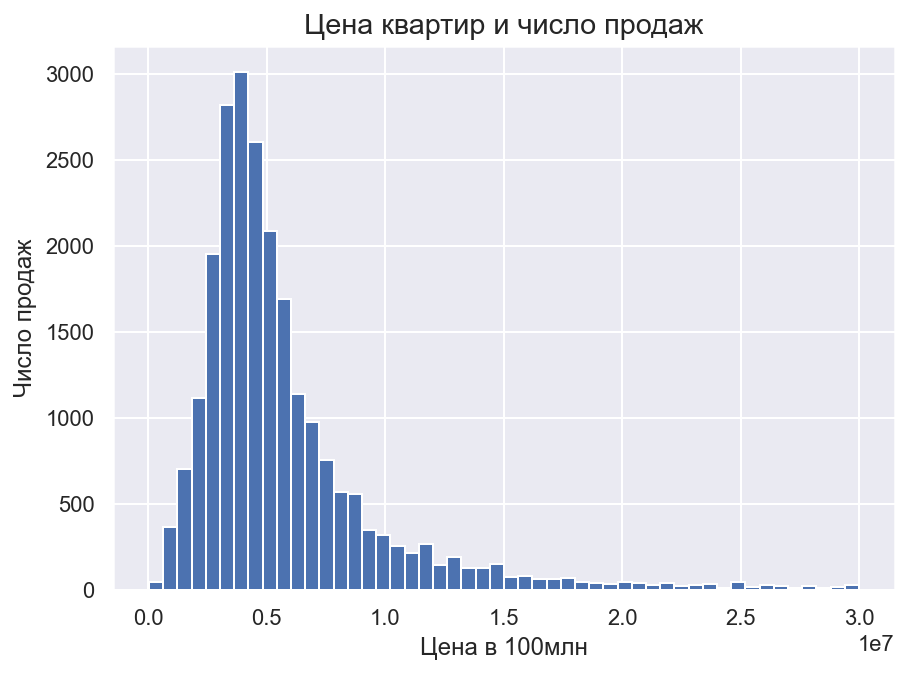

In [95]:
plt.figure(figsize=(7,5))
plt.hist(bins=50, range=(20000, 30000000), x='last_price', data=df);
plt.title('Цена квартир и число продаж', size='large');
plt.ylabel('Число продаж');
plt.xlabel('Цена в 100млн', size= 'medium');


In [96]:
df.last_price.describe()

count        23,698.00
mean      6,541,656.95
std      10,887,230.24
min          12,190.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,800,000.00
max     763,000,000.00
Name: last_price, dtype: float64

Уберем экстримальные значения чтобы они не влияли на дальнейшую выборку

In [97]:
df = df.drop(df[df['last_price'] >= df['last_price'].quantile(.999)].index)

In [98]:
df.total_area.describe()

count   23,674.00
mean        60.03
std         33.81
min         12.00
25%         40.00
50%         52.00
75%         69.70
max        590.00
Name: total_area, dtype: float64

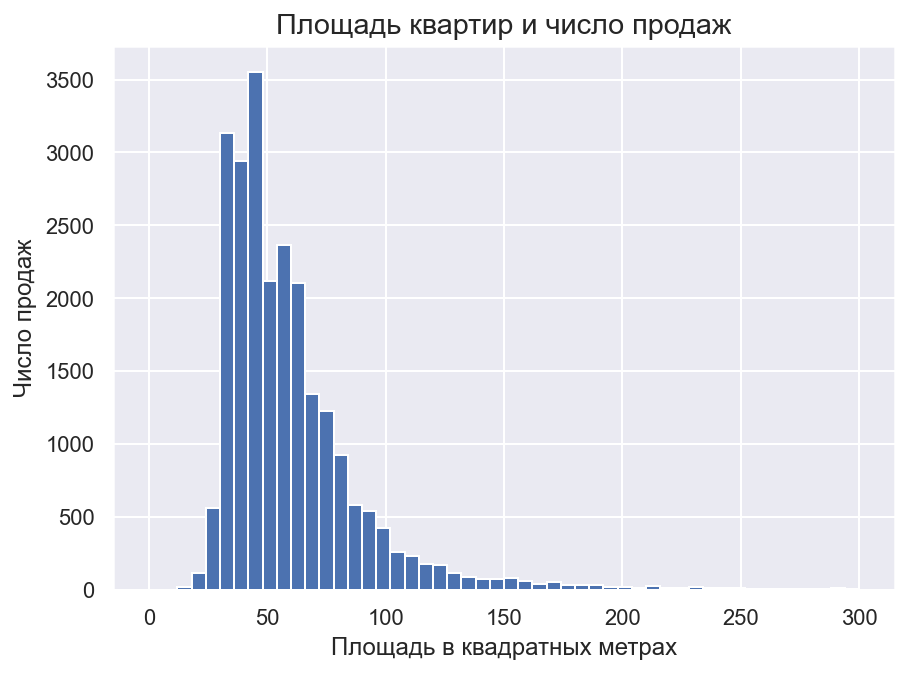

In [99]:
plt.figure(figsize=(7,5))
plt.hist(bins=50, range=(0, 300), x='total_area', data=df);
plt.title('Площадь квартир и число продаж', size='large');
plt.ylabel('Число продаж');
plt.xlabel('Площадь в квадратных метрах', size= 'medium');


Наибольшее количество проданныз квартир имели площать между 30 и 60 кв. метров

Гистограмма асимметрична и вполне соответствует реальности ситуации. Больше всего купленных квартир в рацоне 40-50 млн. От нуля и до 40 млн продаж меньше так как цены на недвижимость начинаются с определенной отметки. Чем выше цена - тем меньше число продаж  

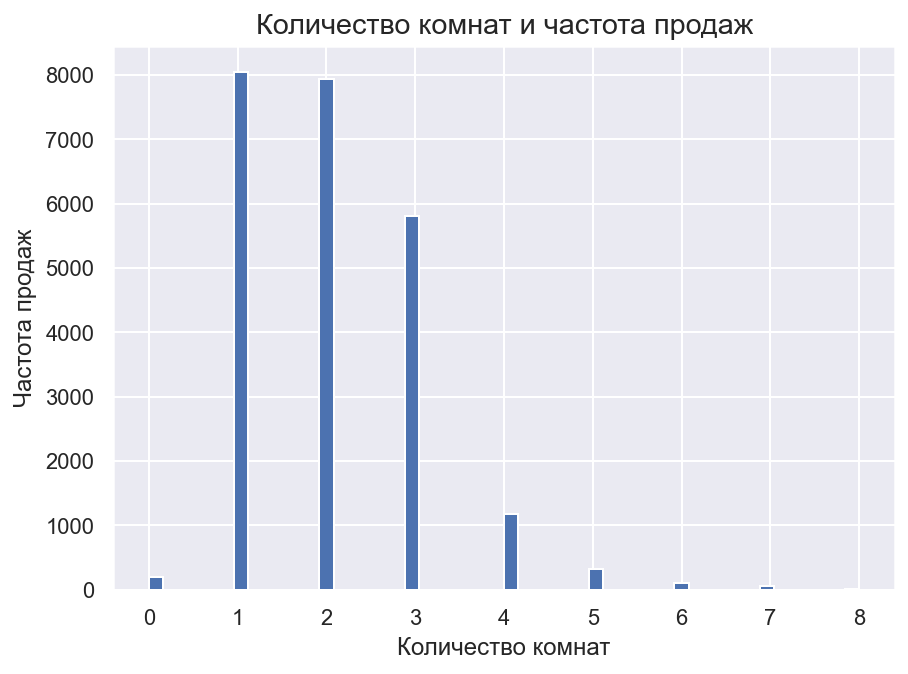

In [100]:
plt.figure(figsize=(7,5))
plt.hist(bins=50, range=(0, 8), x='rooms', data=df);
plt.title('Количество комнат и частота продаж', size='large');
plt.ylabel('Частота продаж');
plt.xlabel('Количество комнат', size= 'medium');

График указывает на то что больше всего проданных квартир было именно однокомнатных и двухкомнатных, чем больше комнат тем выше цена - тем меньше продаж

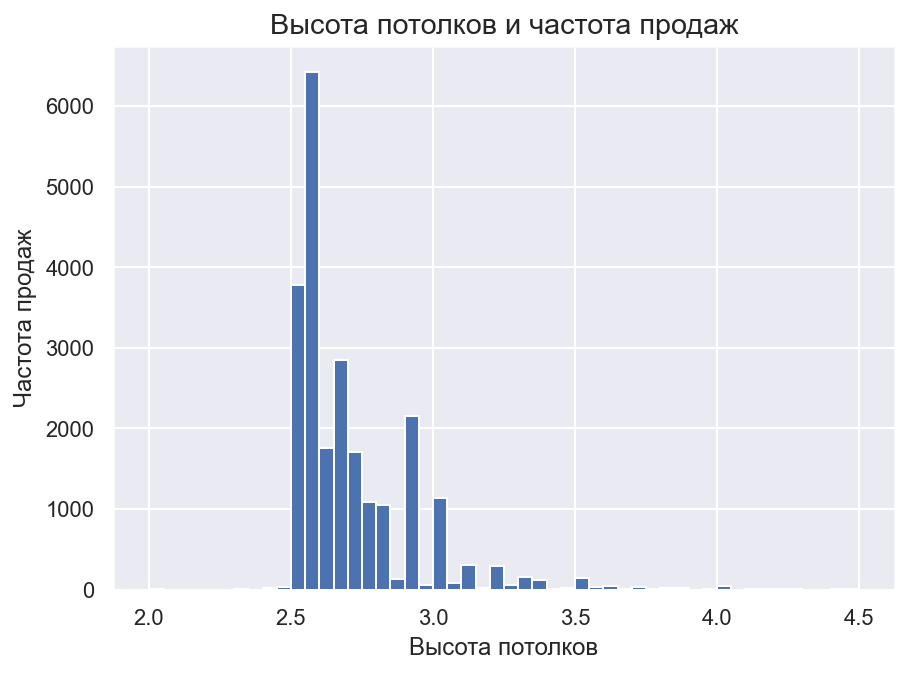

In [101]:
plt.figure(figsize=(7,5))
plt.hist(bins=50, range=(2, 4.5), x='ceiling_height', data=df,);
plt.title('Высота потолков и частота продаж', size='large');
plt.ylabel('Частота продаж');
plt.xlabel('Высота потолков', size= 'medium');

Cуществует несколько типов зданий которые очень расспространены по России, и высота потолков часто типичная, гистограмма на это указывает

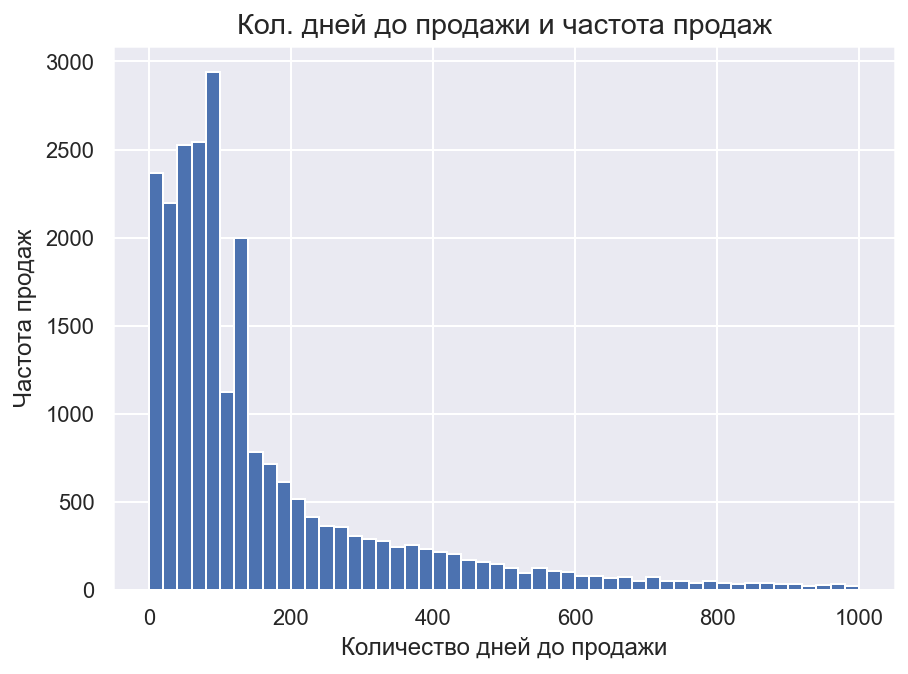

In [102]:
plt.figure(figsize=(7,5))
plt.hist(bins=50, range=(0, 1000), x='days_exposition', data=df,);
plt.title('Кол. дней до продажи и частота продаж', size='large');
plt.ylabel('Частота продаж');
plt.xlabel('Количество дней до продажи', size= 'medium');

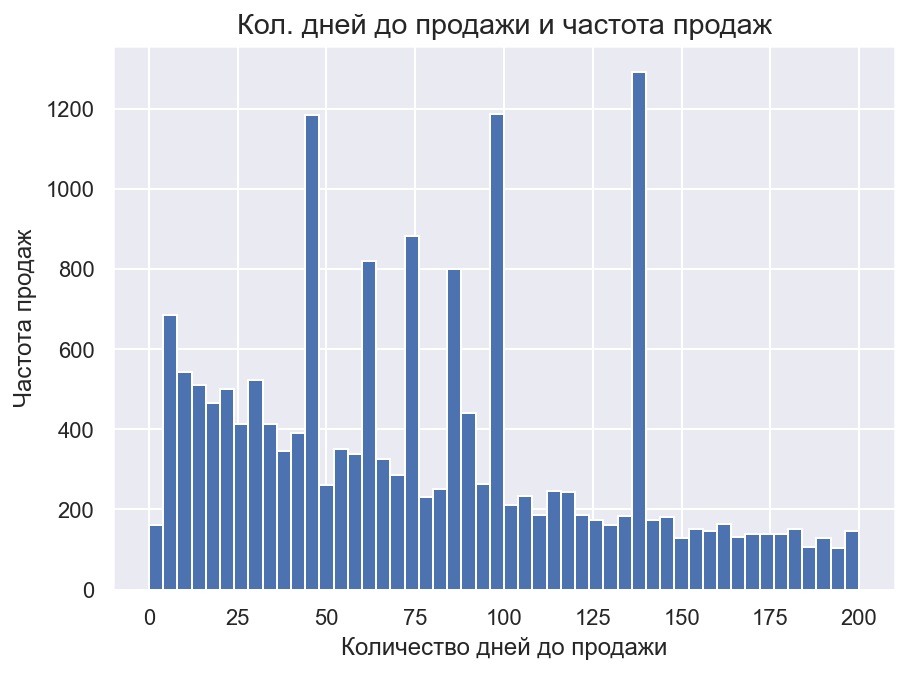

In [103]:
plt.figure(figsize=(7,5))
plt.hist(bins=50, range=(0, 200), x='days_exposition', data=df,);
plt.title('Кол. дней до продажи и частота продаж', size='large');
plt.ylabel('Частота продаж');
plt.xlabel('Количество дней до продажи', size= 'medium');

Мы наблюдаем довольно странные скачки в числе продаж после определенного количество дней. Может это те промежутки времени после которых обьявление возвращается на первую страницу а может это просто какаето особенность автоматизированной системы

In [104]:
df.days_exposition.describe()

count   23,674.00
mean       170.62
std        206.20
min          1.00
25%         45.00
50%         96.00
75%        198.00
max      1,580.00
Name: days_exposition, dtype: float64

- Половина из всех выставленных квартир продаются меньше чем за 96 дней можно считать что обычно квартиры продаются примерно за 3 месяца
- 25% квартир продали меньше чем за 45 дней
- Можно считать что если квартира продалась за 45 дней или быстрее - повезло, квартира продалась быстро
- Если на продажу ушло более 200 дней, продажа затянулась
- Среднее число дней ожидания продажи ровно 170 но на него сильно влияют крайние значения

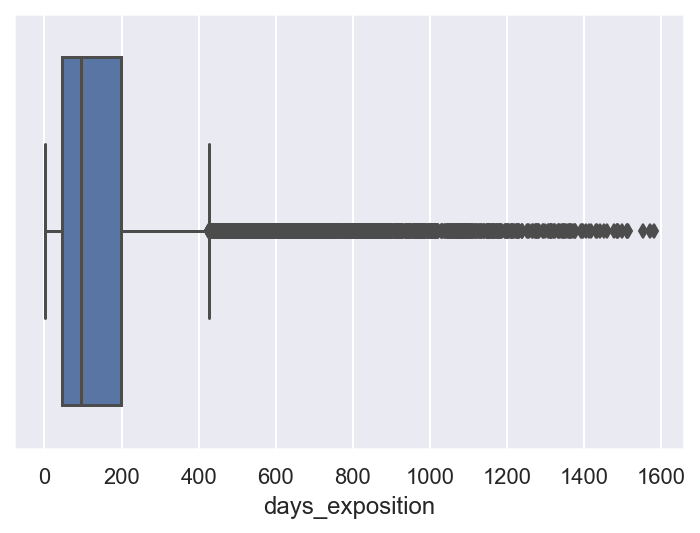

In [105]:
sns.boxplot(data=df, x='days_exposition');

У нас очень много значений похожих на выбросы однако мы не можем от них избавиться так как это вполне реалистичные данные. Они не сильно помешают нам в дальнейшем анализе

In [106]:
df.square_meter_price.describe()

count    23,674.00
mean     98,810.61
std      44,450.88
min         111.83
25%      76,562.50
50%      94,997.75
75%     114,155.18
max     995,983.94
Name: square_meter_price, dtype: float64

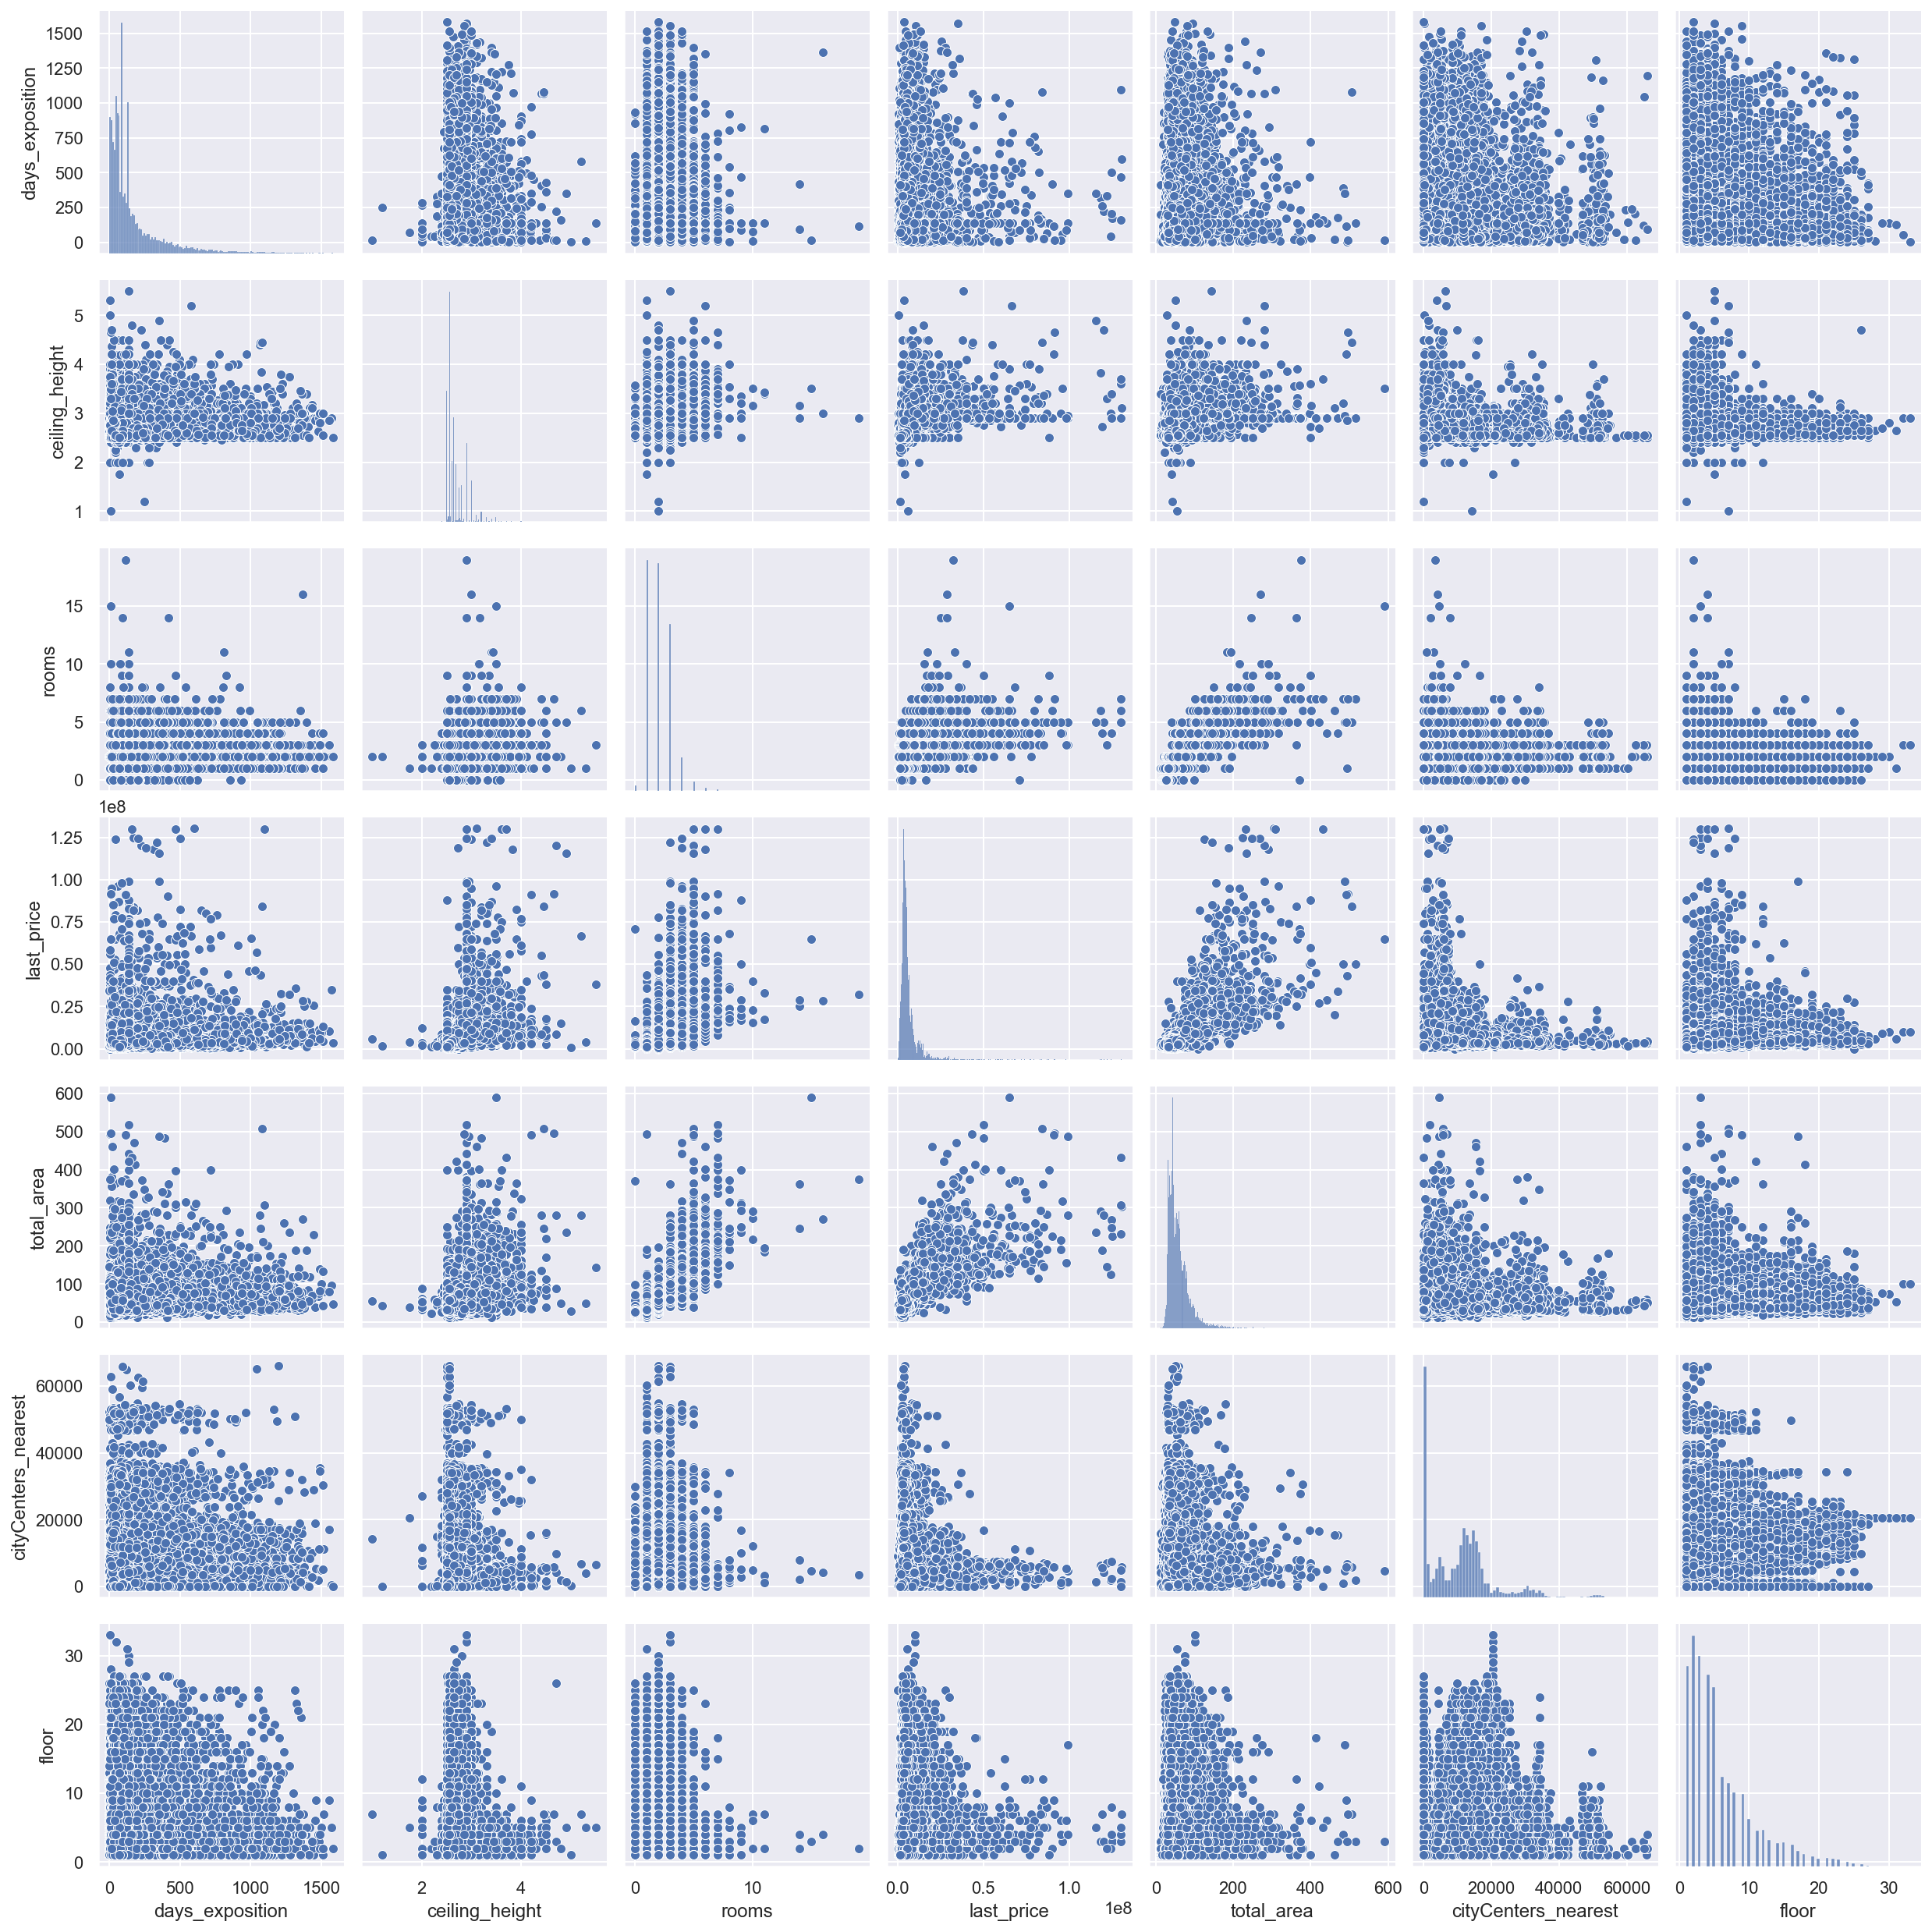

In [107]:
features = ['days_exposition', 'ceiling_height', 'rooms', 'last_price', 'total_area', 'cityCenters_nearest', 'floor']
sns.pairplot(df[features]);

In [108]:
features_2 = ['floor_cat', 'weekday', 'last_price']

map_floor_cat = {
    'первый': 0,
    'последний': 1,
    'другой': 2
}

df['floor_cat'] = df['floor_cat'].map(map_floor_cat)

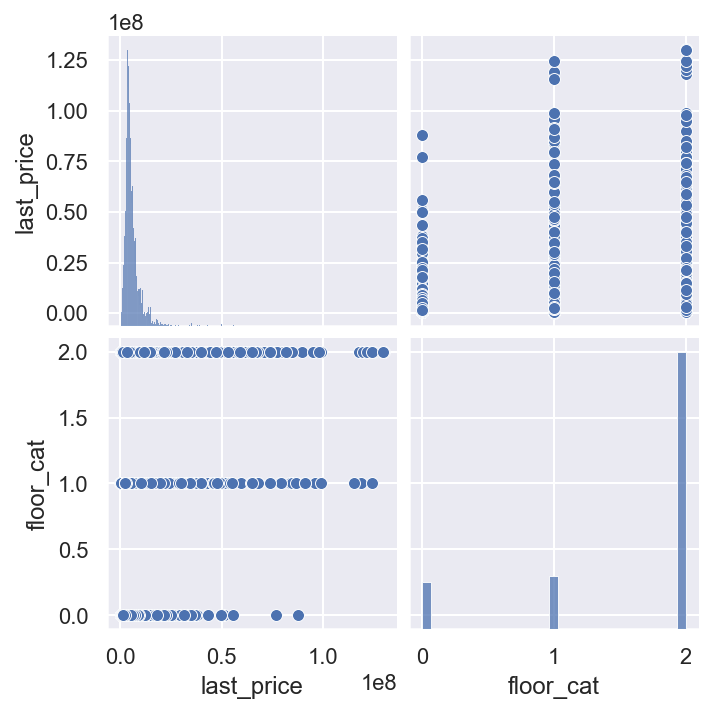

In [109]:
sns.pairplot(df[['last_price', 'floor_cat']]);

Линейная зависимость просматривается у следующих признаков:
- цена и общая площадь
- цена и число комнат
- цена и высота потолков

На графиках просматривается отрицательная зависимость между:

- ценой и расстоянием до центра - чем она больше тем дешевле квартиры.
- ценой и временем ожидания - чем больше цена тем быстрей квартиры покупают.
- ценой и этажом - чем больше цена тем ниже этаж - > но при этом первые и последние этажи ценятся меньше чем все остальные

 


In [110]:
table = df['locality'].value_counts().sort_values(ascending=False)

names = []
for index in table[:11].index:
    names.append(index)

df_popular = df[df['locality'].isin(names)]

In [111]:
df_popular.groupby('locality').agg({'last_price': ['mean','count'], 'square_meter_price': 'mean'}).sort_values(('last_price', 'mean'), ascending=False)

last_price        square_meter_price
                        mean  count               mean
locality                                              
Санкт-Петербург 7,722,122.35  15745         113,890.82
Пушкин          6,469,035.95    369         103,125.82
Парголово       4,488,074.80    327          90,175.91
Петергоф        4,423,840.80    201          84,757.56
Кудрово         4,358,688.05    472          95,324.93
Шушары          4,108,081.82    440          78,677.36
Колпино         3,964,021.44    338          75,424.58
Всеволожск      3,789,067.75    398          68,654.47
Мурино          3,678,462.20    590          86,087.51
Гатчина         3,488,336.68    307          68,746.15
Выборг          3,250,983.12    237          58,141.91

Самые маленькие цены в Выборге, а самые дорогие, в Санкт-Петербурге. Пушкин и поселок Парголово на втором и третьем месте

### 5.1 Анализ квартир в центре СПБ

In [112]:
col1 = df[df['locality'] == 'Санкт-Петербург']['cityCenters_nearest']
col2 = df[df['locality'] == 'Санкт-Петербург']['last_price']

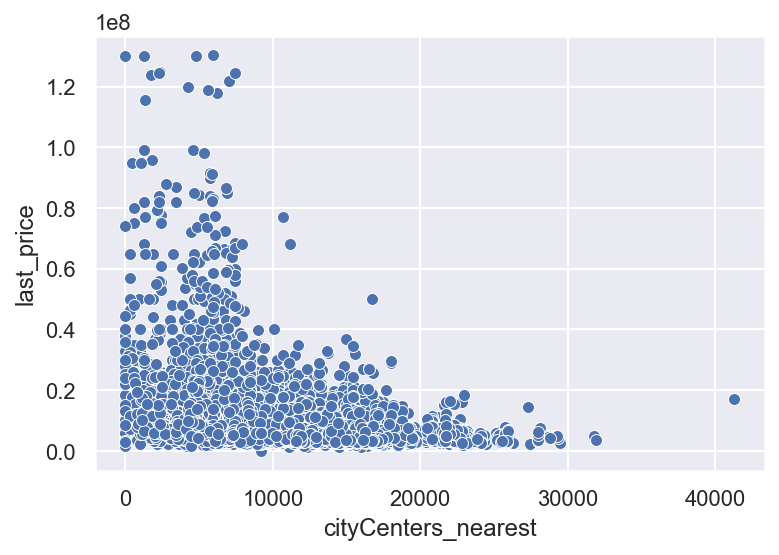

In [113]:
sns.scatterplot(col1, col2);

Мы видим что в зоне 8 - 9 километров от центра города цены резко падают. 

In [114]:
df['center_distance_km'] = (df['cityCenters_nearest'] / 1000).astype('int')

In [115]:
df_spb = df[(df['center_distance_km'] < 10 )& (df['locality_name'] == 'Санкт-Петербург')]

In [116]:
df_spb.groupby('center_distance_km').agg({'last_price': ['mean','max'],
                                         'total_area': ['mean', 'max']})

last_price                total_area       
                            mean            max       mean    max
center_distance_km                                               
0                  17,577,699.29 130,000,000.00      98.64 483.90
1                  16,420,441.66 130,000,000.00     102.51 517.00
2                  14,429,027.15 125,000,000.00      97.40 400.00
3                  11,171,526.37  87,000,000.00      89.78 374.60
4                  13,018,362.23 130,000,000.00      94.29 590.00
5                  13,782,771.13 130,278,280.00      91.79 507.00
6                  13,606,581.00 118,000,000.00      81.58 494.10
7                  11,490,501.76 124,480,000.00      74.58 373.10
8                   8,418,168.99  46,000,000.00      67.61 260.00
9                   6,430,256.64  39,900,000.00      57.70 309.70

Как и на графике видно что цены резко падают при растоянии в 8 километров от центра СПБ. Так же заметно что квартиры в центре больше по размеру чем те что находятся дальше 

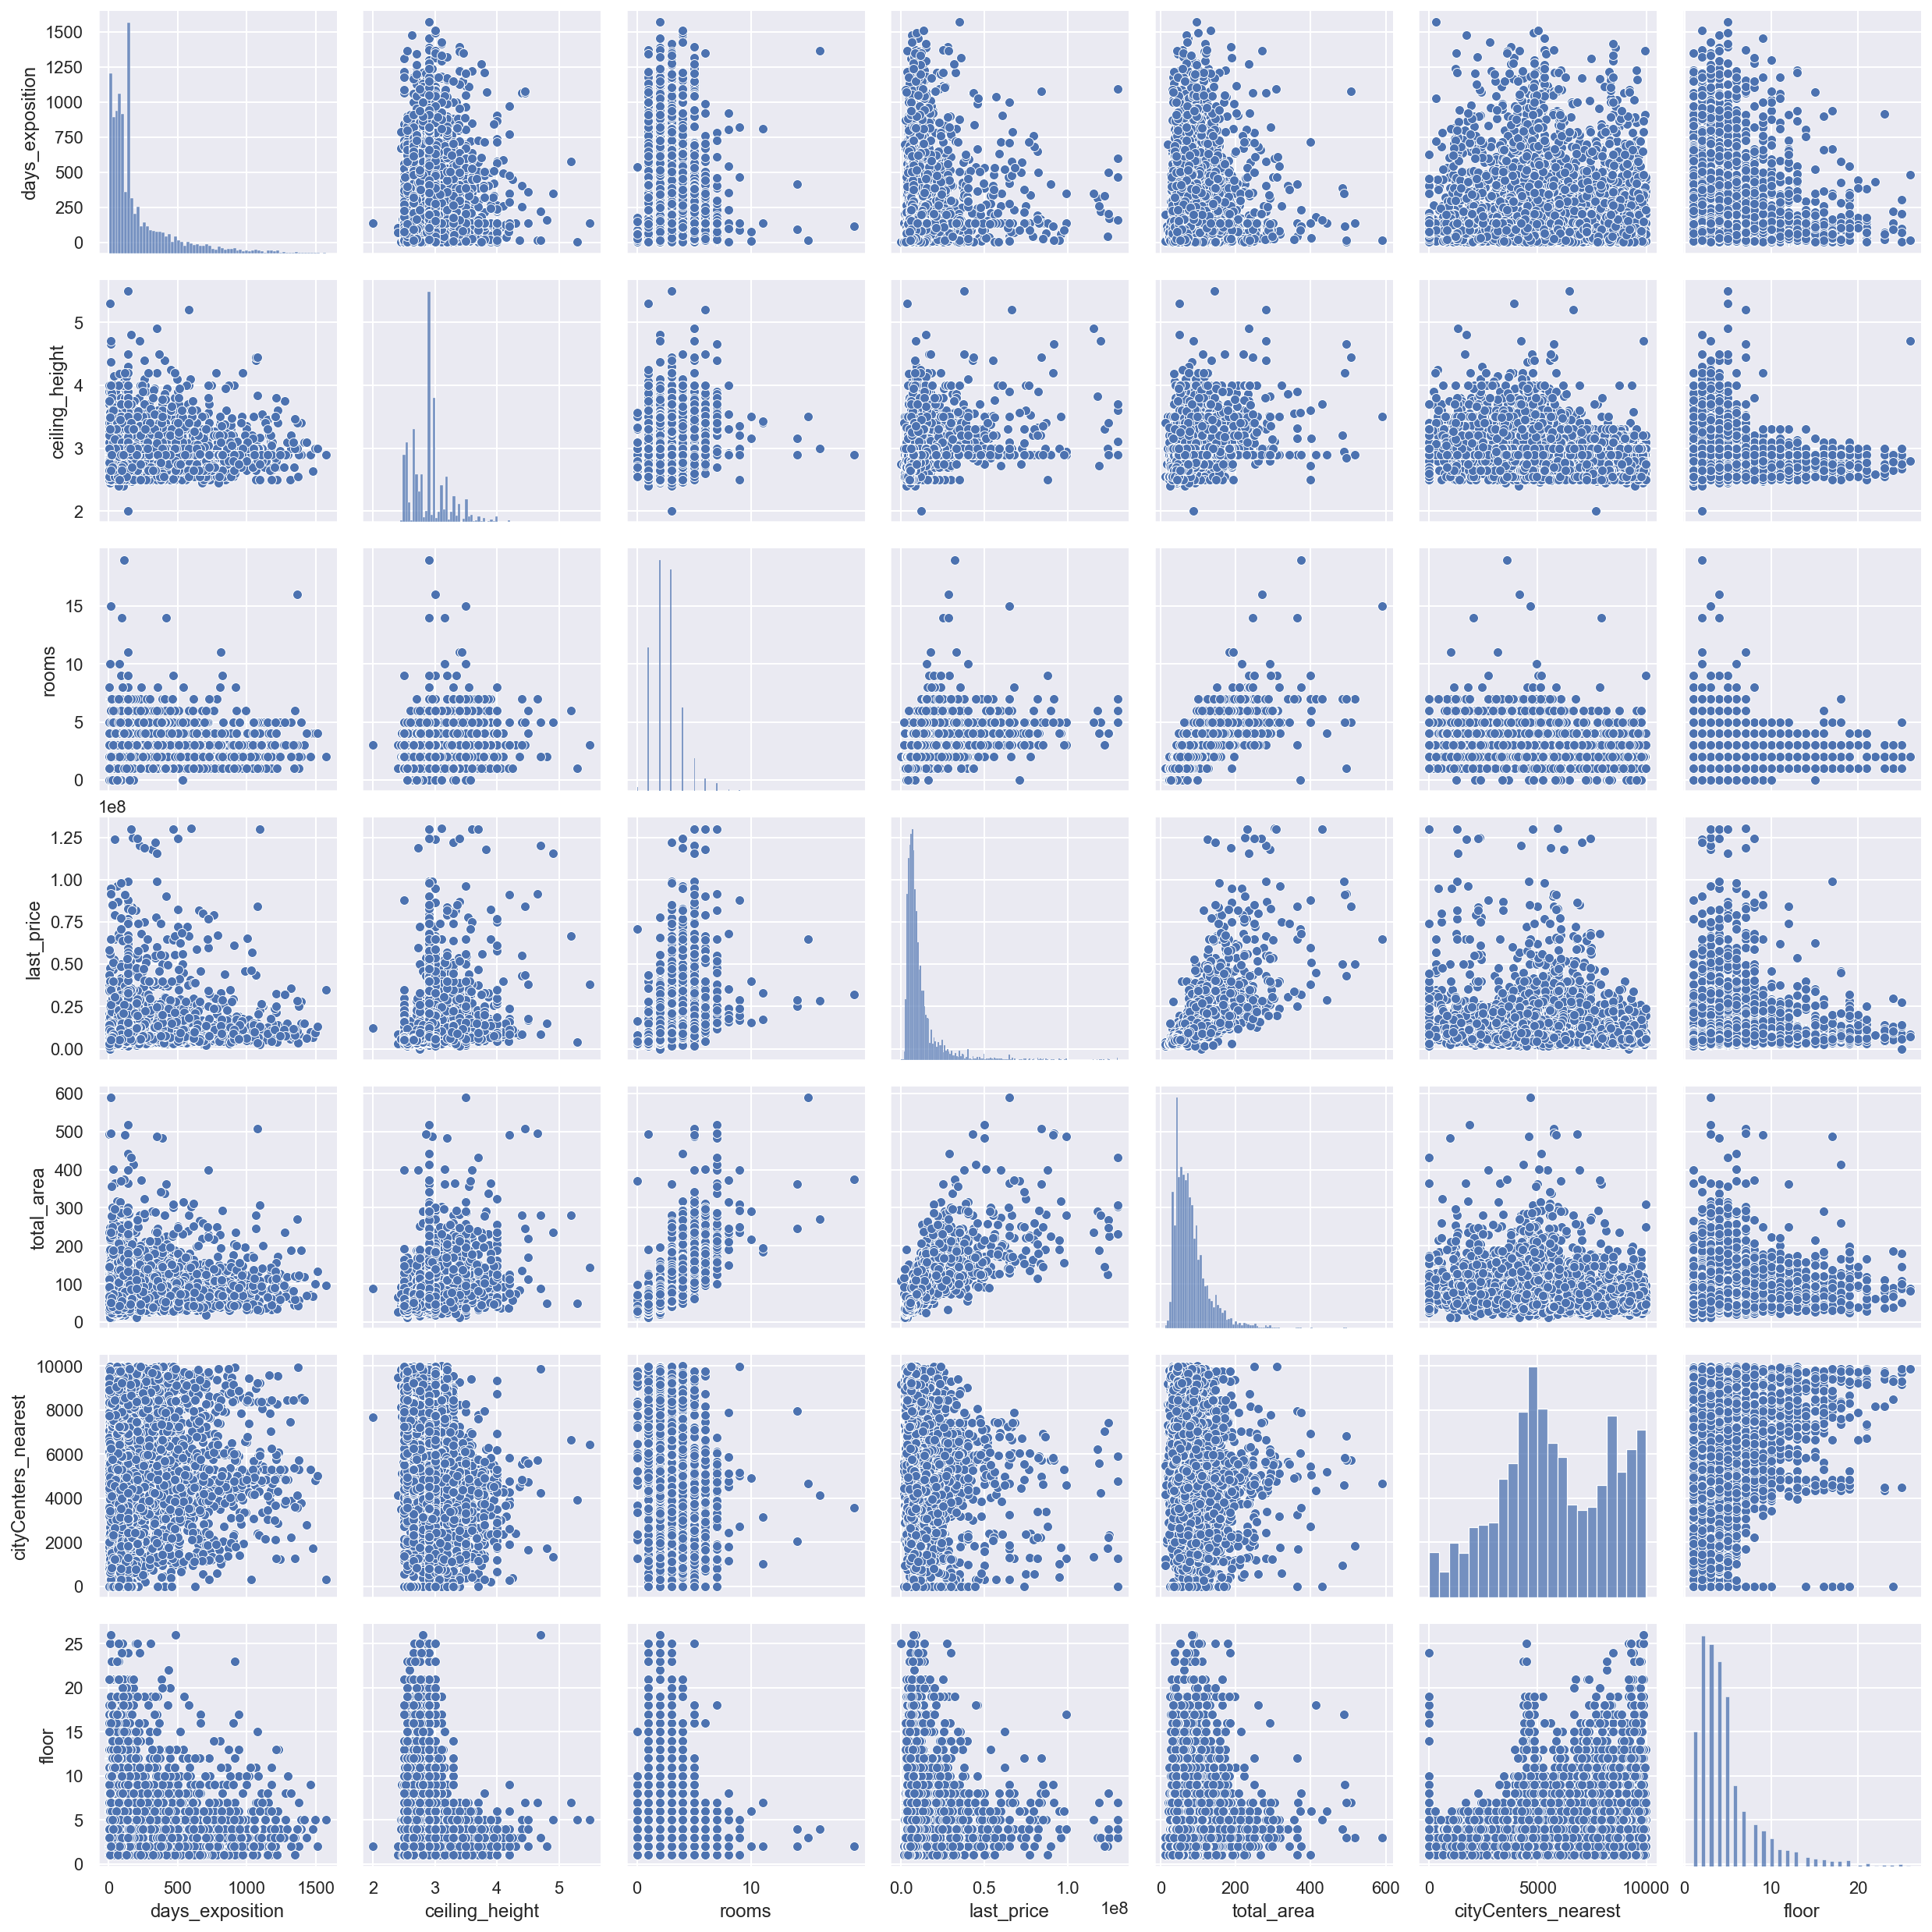

In [117]:
sns.pairplot(df_spb[features]);

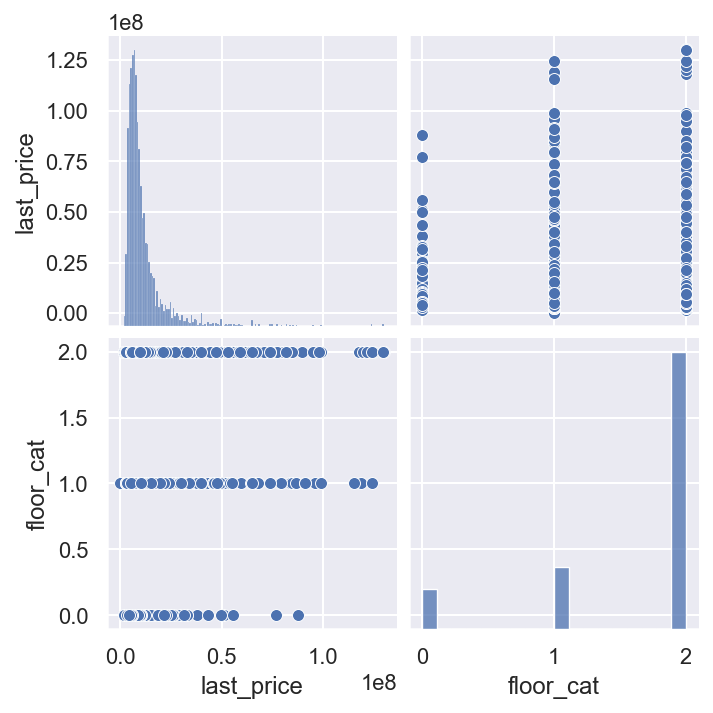

In [118]:
sns.pairplot(df_spb[['last_price', 'floor_cat']]);

Как и у данных всей таблицы в СПБ видна зависимость у следующих признаков:
- цена и общая площадь
- цена и число комнат
- цены и высота потолков

И  отрицательная зависимость между:

- ценой и расстоянием до центра - чем она больше тем дешевле квартиры.
- ценой и временем ожидания - чем больше цена тем быстрей квартиры покупают.
- ценой и этажом - чем больше цена тем ниже этаж

Мы видим на графике что квартиры где этажи категории "другой" стоят дороже. Люди готовы заплатить больше за квартиру которая находится не на первом и не на последнем этаже.


### Подсчитаем взаимозависимость и сверим цифры с нашими заключениями

In [119]:
correlated_columns = [   
"total_area",
"rooms",
"ceiling_height",
"floors_total",
"floor",
"balcony",
"cityCenters_nearest",
"days_exposition"]
for i in correlated_columns:
    print(f'Взаимозависимость {i} с ценой')
    display(df[[i, 'last_price']].corr())

Взаимозависимость total_area с ценой


total_area  last_price
total_area        1.00        0.75
last_price        0.75        1.00

Взаимозависимость rooms с ценой


rooms  last_price
rooms        1.00        0.46
last_price   0.46        1.00

Взаимозависимость ceiling_height с ценой


ceiling_height  last_price
ceiling_height            1.00        0.49
last_price                0.49        1.00

Взаимозависимость floors_total с ценой


floors_total  last_price
floors_total          1.00        0.00
last_price            0.00        1.00

Взаимозависимость floor с ценой


floor  last_price
floor        1.00        0.03
last_price   0.03        1.00

Взаимозависимость balcony с ценой


balcony  last_price
balcony        1.00        0.01
last_price     0.01        1.00

Взаимозависимость cityCenters_nearest с ценой


cityCenters_nearest  last_price
cityCenters_nearest                 1.00       -0.06
last_price                         -0.06        1.00

Взаимозависимость days_exposition с ценой


days_exposition  last_price
days_exposition             1.00        0.10
last_price                  0.10        1.00

По таблицам видно что цена как мы уже определили, зависит в основном от:
- Площади квартиры
- Числа комнат (что тоже зависит от площади кв.)
- Высоты потолков

### 5.2 Зависимость цены и скорости продажи в зависимости от даты публикации

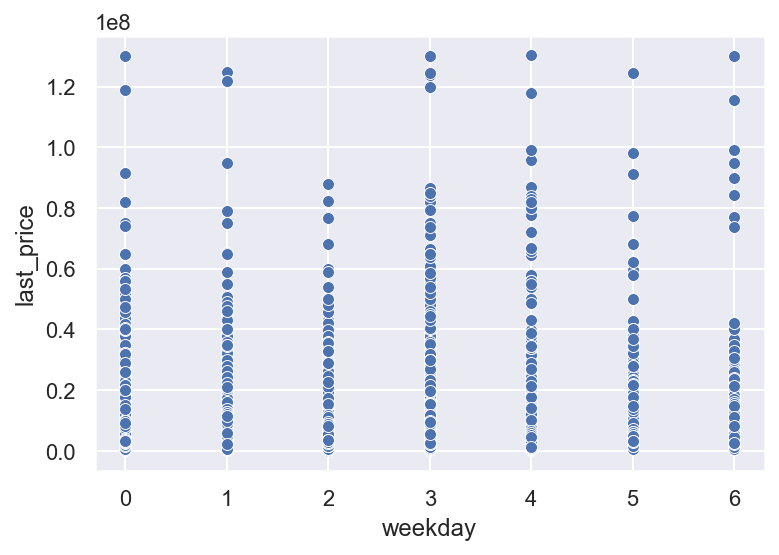

In [120]:
sns.scatterplot(x='weekday', y='last_price', data=df);

График указывает на то что обьявлений меньше на выходные и больше всего в середине недели. Проверим на цифрах если это так

In [121]:
df.groupby('weekday').agg({'last_price':['mean', 'count', 'median']})

last_price                   
                mean count       median
weekday                                
0       6,322,330.84  3608 4,650,000.00
1       6,227,288.83  4179 4,709,190.00
2       6,234,321.78  3967 4,700,000.00
3       6,643,075.84  4293 4,650,000.00
4       6,224,137.24  3996 4,580,000.00
5       6,191,921.55  1932 4,550,000.00
6       6,246,180.30  1699 4,550,000.00

Данные в таблице подтверждают то что больше всего обьявлений появляются во вторник и в четверг, немного меньше во в понедельник, среду и пятницу. На выходных вдвое меньше обьявлений. На цену вышедшие в разные дни обьявления никак не влияют

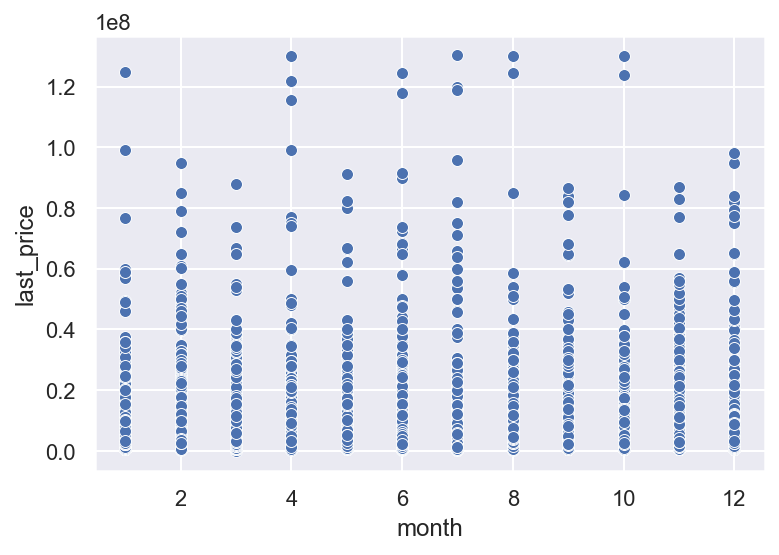

In [122]:
sns.scatterplot(x='month', y='last_price', data=df);

In [123]:
df.groupby('month').agg({'last_price':['mean', 'count', 'median']})

last_price                   
              mean count       median
month                                
1     6,456,842.25  1498 4,600,000.00
2     6,270,106.25  2638 4,650,000.00
3     6,071,752.70  2583 4,650,000.00
4     6,282,137.81  2374 4,800,000.00
5     6,323,863.61  1272 4,500,000.00
6     6,310,269.40  1760 4,400,000.00
7     6,570,618.09  1694 4,650,000.00
8     6,262,089.68  1743 4,570,000.00
9     6,381,839.45  1978 4,700,000.00
10    6,097,351.93  2125 4,550,000.00
11    6,396,578.50  2370 4,700,000.00
12    6,580,995.29  1639 4,700,000.00

In [124]:
df.head()

total_images    last_price  total_area first_day_exposition  rooms  \
0            20 13,000,000.00      108.00           2019-03-07      3   
1             7  3,350,000.00       40.40           2018-12-04      1   
2            10  5,196,000.00       56.00           2015-08-20      2   
3             0 64,900,000.00      159.00           2015-07-24      3   
4             2 10,000,000.00      100.00           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  studio  ...  \
0            2.70            16        51.00      8   False  ...   
1            2.55            11        18.60      1   False  ...   
2            2.65             5        34.30      4   False  ...   
3            2.90            14         0.57      9   False  ...   
4            3.03            14        32.00     13   False  ...   

   total_living_coeff  size_category         locality square_meter_price  \
0                0.47             XL  Санкт-Петербург         120,370.37   
1                0.46         medium           Шушары          82,920.79   
2                0.61          large  Санкт-Петербург          92,785.71   
3                0.00             XL  Санкт-Петербург         408,176.10   
4                0.32             XL  Санкт-Петербург         100,000.00   

   kitchen_total_coeff  year  month  weekday  floor_cat  center_distance_km  
0                 0.23  2019      3        3          2                  16  
1                 0.27  2018     12        1          0                  18  
2                 0.15  2015      8        3          2                  13  
3                 0.08  2015      7        4          2                   6  
4                 0.41  2018      6        1          2                   8  

[5 rows x 32 columns]

## Общий вывод


Предобработка:

- обработаны пропуски которые возможно было заполнить
- некоторые выбросы были изменены, другие удалены
- дата размещения объявления преобразована в необходимый формат
- данные с названием города были обработаны

В данных остались значения которые можно определить как выбросы посмотрев на их гистограмму однако они соответветствуют реальной ситуации на рынке недвижимости. Есть дома/квартиры сильно отличающиеся друг от друга по цене и по площади

Добавлены в таблиц:

- стоимость кв. метра
- день, месяц, год
- категория жилья в зависимотсти от этажа
- соотношения жилой и кухонной площади к общей
- расстояние до центра в км.
- название города/поселка
- категория жилья в зависимости от размера


Чаще всего встречаются в обьявлениях:

- цена около 4 млн.
- площадь 40-50 м2
- 2-4 комнат с высотой потолков 2.5 или 2.6 метра

Факторы от которых зависит цена жилья:

- площадь
- количество комнат
- этаж (на первом и последнем квартире дешевле)
- растояние до центра
